# 🚖 Project: Predicting Taxi Trip Duration

## 🎯 Objective  
The goal of this project is to **predict the duration of taxi rides** in New York City using machine learning techniques.

---

## 📂 Data Source  
This project uses data from the [Kaggle competition: NYC Taxi Trip Duration](https://www.kaggle.com/competitions/nyc-taxi-trip-duration).

---

## 💡 Hypothesis  
We hypothesize that it is possible to build a predictive model that accurately estimates the **duration of a taxi ride** using features such as:

- 📍 **Pickup and dropoff locations**  
- ⏰ **Pickup time**  
- 👥 **Passenger count**  
- ➕ **Other derived or engineered features**

---

In [1]:
#all imports for the notebook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import scipy.stats as stats
import re
import joblib


from scipy.stats import ttest_ind, levene, mannwhitneyu, kruskal, friedmanchisquare
from scipy.stats import skew, kurtosis
from termcolor import colored
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, IsolationForest
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from pytorch_tabnet.tab_model import TabNetRegressor

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
#Global Variables
database = r'D:\DataScience&AI - Uti Itai\Projects\002 - second project\nyc-taxi-trip-duration\train.csv'
magic_num = 42
target = 'trip_duration'

features  = [
    'vendor_id',
    'passenger_count',
    'pickup_hour',
    'pickup_day_of_week',
    #'pickup_day_of_year',
    'month',
    #'is_weekend',
    'store_and_fwd_flag',
    'haversine_distance',
    'heavy_hour_traffic',
    'heavy_day_traffic' ,
    'count_trip_per_day_anomaly',
    'pickup_cluster',
    'dropoff_cluster'
]

features_to_cluster = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude'
]


#Var for futre use if needed - they will get generated in the code

#cluster_scalar - the scalar used to add new data for cluster
#cluster_kmenas - the kmenas used to add new data for cluster
#pickup_features, dropoff_features - the names of the features used for clustering

#iso_model - the iso model file use to determine if new data is anomality detection
#iso_model_features - the iso model feature list used for the animality detection


In [3]:
# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
#####Functions#####

#data transfomr from string to data
def data_string_wild_to_date(df, column_wildcard):
    df_converted = df.copy()
    compiled_pattern = re.compile(column_wildcard.replace('*', '.*'))
    columns_to_convert = [col for col in df_converted.columns if compiled_pattern.fullmatch(col)]
    print(f"Columns matching wildcard '{column_wildcard}': {columns_to_convert}")
    for col in columns_to_convert:
        try:
            df_converted[col] = pd.to_datetime(df_converted[col], errors='coerce')
            print(f"Successfully converted column '{col}' to datetime.")
        except ValueError as e:
            print(f"Error converting column '{col}' to datetime: {e}")
            print(f"Make sure the data in column '{col}' has a recognizable date/time format.")
        except Exception as e:
            print(f"An unexpected error occurred while converting column '{col}': {e}")
    return df_converted


#data numeric transform to pandas lower case and fill Null with median
def data_pandas_num_low_and_fill_null (df, statistic_name=None):
    df_converted = df.copy()
    numerical_cols_clean = df_converted.select_dtypes(include=['number']).columns
    for col in numerical_cols_clean:
        if statistic_name is not None:  # Check if a statistic_name is provided
            if statistic_name.lower() == 'mean':
                fill_value = df_converted[col].mean()
            elif statistic_name.lower() == 'median':
                fill_value = df_converted[col].median()
            elif statistic_name.lower() == 'mode':
                mode_series = df_converted[col].mode()
                fill_value = mode_series.iloc[0] if not mode_series.empty else np.nan
            else:
                print(f"Invalid statistic_name: '{statistic_name}'. No filling performed for column: {col}")
                continue
            df_converted[col] = df_converted[col].fillna(fill_value).replace('NULL', fill_value)
    df_converted = df_converted.astype({col: str(df_converted[col].dtype).lower() for col in df_converted.columns})
    return df_converted


#data transform string to category if less than max_unique_values
def data_str_to_cat (df, max_unique_values = 20):
    df_converted = df.copy()
    for col in df_converted.select_dtypes(include='string'):
        if df_converted[col].nunique() <= max_unique_values:
            df_converted[col] = df_converted[col].astype('category')
    return df_converted


def plot_scatter_matrix(df, sample_size=5000):
    df_numeric = df.select_dtypes(include='number')
    if len(df) > sample_size:
        df_sample = df_numeric.sample(sample_size, random_state=magic_num)
    else:
        df_sample = df_numeric

    sns.pairplot(df_sample, diag_kind='kde')
    plt.suptitle('Scatter Matrix of Numeric Variables', y=1.02)
    plt.show()



#Generate own data stats
def generate_data_statistics(df):
    categorical_cols = df.select_dtypes(include=['category', 'object']).columns
    numerical_cols = df.select_dtypes(include=['number']).columns
    stats_df = None
    stats_categorical = None

    # ---------- Numerical Stats ----------
    if len(numerical_cols) > 0:
        stats_df = pd.DataFrame(index=numerical_cols)
        mode_count = df[numerical_cols].apply(lambda x: x.value_counts().iloc[0] if not x.value_counts().empty else None)
        mode_percentage = df[numerical_cols].apply(lambda x: (x.value_counts().iloc[0] / len(x)) * 100 if not x.value_counts().empty else None)
        stats_df['Min'] = df[numerical_cols].min()
        stats_df['Max'] = df[numerical_cols].max()
        stats_df['AVG'] = df[numerical_cols].mean()
        stats_df['Median'] = df[numerical_cols].median()
        stats_df['Range'] = stats_df['Max'] - stats_df['Min']
        stats_df['STD'] = df[numerical_cols].std()
        stats_df['VAR'] = df[numerical_cols].var()
        stats_df['SUM'] = df[numerical_cols].sum()
        stats_df['Count'] = df[numerical_cols].count()
        stats_df['Mode'] = df[numerical_cols].mode().iloc[0]
        stats_df['Mode Count'] = mode_count
        stats_df['Mode Percentage'] = mode_percentage
        stats_df['5%'] = df[numerical_cols].quantile(0.05)
        stats_df['Q1'] = df[numerical_cols].quantile(0.25)
        stats_df['Q3'] = df[numerical_cols].quantile(0.75)
        stats_df['95%'] = df[numerical_cols].quantile(0.95)
        stats_df['IQR'] = stats_df['Q3'] - stats_df['Q1']
        stats_df['VAR'] = stats_df['VAR'].apply(lambda x: f"{x:,.2f}")
        stats_df['SUM'] = stats_df['SUM'].apply(lambda x: f"{x:,.2f}")
    # ---------- Categorical Stats ----------
    if len(categorical_cols) > 0:
        stats_categorical = pd.DataFrame(index=categorical_cols)
        stats_categorical['Mode'] = df[categorical_cols].mode().iloc[0]
        stats_categorical['Count'] = df[categorical_cols].apply(lambda x: x.value_counts().iloc[0] if not x.value_counts().empty else None)
        stats_categorical['Unique Count'] = df[categorical_cols].nunique()
        mode_count_cat = df[categorical_cols].apply(lambda x: x.value_counts().iloc[0] if not x.value_counts().empty else None)
        mode_percentage_cat = df[categorical_cols].apply(lambda x: (x.value_counts().iloc[0] / len(x)) * 100 if not x.value_counts().empty else None)
        stats_categorical['Mode Count'] = mode_count_cat
        stats_categorical['Mode Percentage'] = mode_percentage_cat
    return stats_df, stats_categorical


def plot_all_histograms(df, bins=20, kde=True):
    for column in df.columns:
        column_dtype = df[column].dtype
        plt.figure(figsize=(10, 6))
        if pd.api.types.is_numeric_dtype(column_dtype):
            sns.histplot(df[column].dropna(), bins=bins, edgecolor='black', kde=kde)
            plt.title(f'Histogram of {column} (dtype: {column_dtype})')
            plt.xlabel(column)
            plt.ylabel('Frequency')
        elif (
            isinstance(column_dtype, pd.CategoricalDtype) or
            pd.api.types.is_object_dtype(column_dtype) or
            pd.api.types.is_bool_dtype(column_dtype)
        ):
            df[column].value_counts().plot(kind='bar', edgecolor='black')
            plt.title(f'Bar Plot of {column} (dtype: {column_dtype})')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.xticks(rotation=45)
        else:
            plt.close()
            continue
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def plot_histogram_filtered(df: pd.DataFrame, col_name: str, condition: str = None, value: float = None) -> None:
    if col_name not in df.columns:
        print(f"Error: DataFrame must contain the column: '{col_name}'.")
        return
    try:
        plt.figure(figsize=(8, 6))  # Consistent figure size
        if condition and value is not None:  # Check if both condition and value are provided
            if condition == '<':
                filtered_df = df[df[col_name] < value].copy()
            elif condition == '>':
                filtered_df = df[df[col_name] > value].copy()
            elif condition == '<=':
                filtered_df = df[df[col_name] <= value].copy()
            elif condition == '>=':
                filtered_df = df[df[col_name] >= value].copy()
            elif condition == '=':
                filtered_df = df[df[col_name] == value].copy()
            else:
                print("Error: Invalid condition. Please use '<', '>', '<=', '>=', or '='.")
                return
            plt.hist(filtered_df[col_name], bins=20)
            plt.title(f'Distribution of {col_name} (Filtered by {condition} {value})')
        else:
            plt.hist(df[col_name], bins=20)  # Plot the entire column if no condition
            plt.title(f'Distribution of {col_name}')  # Default title
        plt.xlabel(col_name)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    except KeyError:
        print(f"Error: Column not found. Please check the column name.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


def plot_correlation_heatmap(df):
    corr = df.select_dtypes(include='number').corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()


def plot_boxplots_vs_target(df, target_col, max_categories=10):
    for col in df.columns:
        if col == target_col:
            continue
        plt.figure(figsize=(8, 5))
        if (
            isinstance(df[col].dtype, pd.CategoricalDtype) or
            pd.api.types.is_object_dtype(df[col]) or
            pd.api.types.is_bool_dtype(df[col]) or
            df[col].nunique() <= max_categories
        ):
            sns.boxplot(x=df[col], y=df[target_col])
            plt.title(f'{target_col} by {col}')
            plt.xticks(rotation=45)
        elif pd.api.types.is_numeric_dtype(df[col]):
            try:
                df['_binned'] = pd.qcut(df[col], q=5, duplicates='drop')
                sns.boxplot(x=df['_binned'], y=df[target_col])
                plt.title(f'{target_col} by binned {col}')
                plt.xticks(rotation=45)
            except ValueError:
                plt.close()
                continue
        else:
            plt.close()
            continue
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.tight_layout()
        plt.show()
    if '_binned' in df.columns:
        df.drop(columns=['_binned'], inplace=True)


#skew and kurtosis
def analyze_skew_kurtosis(df):
    numerical_cols = df.select_dtypes(include=['number']).columns
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')
    skewness = df[numerical_cols].apply(lambda x: round(skew(x.dropna()), 2) if len(x.dropna()) > 1 else None)
    kurt = df[numerical_cols].apply(lambda x: round(kurtosis(x.dropna()), 2) if len(x.dropna()) > 1 else None)
    normality = pd.Series(index=skewness.index, dtype='object')
    for col in skewness.index:
        s = skewness[col]
        k = kurt[col]
        if s is None or k is None:
            normality[col] = 'Insufficient Data'
        elif (abs(s) <= 0.75 and 2.25 <= k <= 3.75) or (2.70 <= k <= 3.3):
            normality[col] = 'Normal'
        else:
            normality[col] = 'Not Normal'
    skew_type = skewness.apply(lambda x: 'Normal Skew' if x is not None and abs(x) <= 0.5 else ('Right Skew' if x is not None and x > 0 else ('Left Skew' if x is not None else None)))
    skew_kurtosis_df = pd.DataFrame({
        'Skewness': skewness,
        'Kurtosis': kurt,
        'Normality': normality,
        'Skew Type': skew_type
    })
    return skew_kurtosis_df


#categorial correlations
def chi_square_categorical_corr(df, plot_heatmap=True):
    categorical_columns = df.select_dtypes(include=['category']).columns.tolist()
    p_value_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                p_value_matrix.loc[col1, col2] = None  # or np.nan
            else:
                contingency_table = pd.crosstab(df[col1], df[col2])
                if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
                    p_value_matrix.loc[col1, col2] = p_value
                else:
                    # If one dimension is 1, chi-square test isn't valid
                    p_value_matrix.loc[col1, col2] = None

    print("Chi-Square p-value matrix:")
    print(p_value_matrix)
    if plot_heatmap:
        plt.figure(figsize=(10, 8))
        sns.heatmap(p_value_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5, cbar_kws={'label': 'p-value'})
        plt.title("Chi-Square Test p-values for Categorical Columns")
        plt.tight_layout()
        plt.show()
    return p_value_matrix


def taxi_features_eng(df, low_trip_percentile=0.10):
    df_converted = df.copy()

    # Time features
    df_converted['pickup_hour'] = df_converted['pickup_datetime'].dt.hour
    df_converted['pickup_day_of_week'] = df_converted['pickup_datetime'].dt.dayofweek + 1  # 1=Monday, 7=Sunday
    df_converted['pickup_day_of_year'] = df_converted['pickup_datetime'].dt.dayofyear
    df_converted['month'] = df_converted['pickup_datetime'].dt.month
    df_converted['is_weekend'] = df_converted['pickup_day_of_week'].apply(lambda x: 1 if x >= 6 else 0)

    # Haversine distance
    def haversine_vectorized(lat1, lon1, lat2, lon2):
        R = 6371  # Radius of Earth in km
        lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
        lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c

    df_converted['haversine_distance'] = haversine_vectorized(
        df_converted['pickup_latitude'],
        df_converted['pickup_longitude'],
        df_converted['dropoff_latitude'],
        df_converted['dropoff_longitude']
    )

    # Manhattan distance (approximate)
    mean_lat = df_converted[['pickup_latitude', 'dropoff_latitude']].mean(axis=1)
    km_per_deg_lon = 111 * np.cos(np.radians(mean_lat))
    df_converted['manhattan_distance'] = (
        111 * np.abs(df_converted['pickup_latitude'] - df_converted['dropoff_latitude']) +
        km_per_deg_lon * np.abs(df_converted['pickup_longitude'] - df_converted['dropoff_longitude'])
    )

    # Traffic proxies (safe - no trip_duration)
    hourly_trip_counts = df_converted['pickup_hour'].value_counts()
    daily_trip_counts = df_converted['pickup_day_of_week'].value_counts()
    hourly_threshold = np.percentile(hourly_trip_counts, 75)
    daily_threshold = np.percentile(daily_trip_counts, 75)
    df_converted['hourly_trip_volume'] = df_converted['pickup_hour'].map(hourly_trip_counts)
    df_converted['daily_trip_volume'] = df_converted['pickup_day_of_week'].map(daily_trip_counts)
    df_converted['heavy_hour_traffic'] = (df_converted['hourly_trip_volume'] >= hourly_threshold).astype(int)
    df_converted['heavy_day_traffic'] = (df_converted['daily_trip_volume'] >= daily_threshold).astype(int)
    df_converted.drop(columns=['hourly_trip_volume', 'daily_trip_volume'], inplace=True)

    # Anomaly: unusually low number of trips per day
    trip_counts_per_day = df_converted['pickup_day_of_year'].value_counts()
    low_trip_threshold = trip_counts_per_day.quantile(low_trip_percentile)
    low_traffic_days = trip_counts_per_day[trip_counts_per_day < low_trip_threshold].index
    df_converted['count_trip_per_day_anomaly'] = df_converted['pickup_day_of_year'].isin(low_traffic_days).astype(int)

    return df_converted



def plot_kmeans_elbow_geo(df, features, max_clusters=15, magic_num=magic_num):
    X = df[features].dropna()
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=magic_num, n_init='auto')
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters (Geographic)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.grid(True)
    plt.xticks(range(1, max_clusters + 1))
    plt.show()


def apply_kmeans_cluster(df, features_to_cluster, n_clusters, random_state=magic_num):
    df_clustered = df.copy()
    scaler = StandardScaler()
    # Dynamically extract pickup and dropoff coordinate columns
    pickup_features = [col for col in features_to_cluster if 'pick' in col.lower()]
    dropoff_features = [col for col in features_to_cluster if 'drop' in col.lower()]
    if len(pickup_features) != 2 or len(dropoff_features) != 2:
        raise ValueError(f"Expected exactly 2 pickup and 2 dropoff features, got {len(pickup_features)} pickup and {len(dropoff_features)} dropoff.")
    # Combine all coordinate data
    pickup_coords = df_clustered[pickup_features].values
    dropoff_coords = df_clustered[dropoff_features].values
    combined_coords = np.vstack((pickup_coords, dropoff_coords))
    # Scale coordinates
    combined_scaled = scaler.fit_transform(combined_coords)
    # Fit KMeans on combined data
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    kmeans.fit(combined_scaled)
    # Predict Cluster for pickup and dropoff points
    pickup_scaled = combined_scaled[:len(pickup_coords)]
    dropoff_scaled = combined_scaled[len(pickup_coords):]
    pickup_labels = kmeans.predict(pickup_scaled) + 1
    dropoff_labels = kmeans.predict(dropoff_scaled) + 1
    df_clustered['pickup_cluster'] = pickup_labels
    df_clustered['dropoff_cluster'] = dropoff_labels
    df_clustered['route_cluster'] = (df_clustered['pickup_cluster'].astype(str) + '_' + df_clustered['dropoff_cluster'].astype(str))
    # Inverse transform centroids for plotting
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    cmap = plt.get_cmap('tab10')
    plt.figure(figsize=(16, 9))
    # Plot pickups and dropoffs
    plt.scatter(df_clustered[pickup_features[0]], df_clustered[pickup_features[1]],
                c=pickup_labels, cmap=cmap, marker='o', alpha=0.6, label='_nolegend_')
    plt.scatter(df_clustered[dropoff_features[0]], df_clustered[dropoff_features[1]],
                c=dropoff_labels, cmap=cmap, marker='x', alpha=0.6, label='_nolegend_')
    # Plot cluster centroids with labels
    for i, (lon, lat) in enumerate(centroids):
        plt.scatter(lon, lat, color=cmap(i % 10), marker='o', s=250, edgecolor='black', linewidth=2)
        plt.text(lon, lat, f'{i+1}', fontsize=16, fontweight='bold', ha='center', va='center', color='white')
    legend_patches = [mpatches.Patch(color=cmap(i % 10), label=f'Cluster {i+1}') for i in range(n_clusters)]
    # Black markers for pickup and dropoff, just one each for legend clarity
    pickup_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Pickup')
    dropoff_legend = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=10, label='Dropoff')
    # Combine cluster patches + marker legend handles
    all_handles = legend_patches + [pickup_legend, dropoff_legend]
    plt.legend(handles=all_handles, title='Clusters', fontsize=14)
    plt.title('Pickup and Dropoff Clusters', fontsize=18)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return df_clustered, scaler, kmeans, pickup_features, dropoff_features


def assign_clusters_to_new_data(new_df, scaler, kmeans, pickup_features, dropoff_features):
    new_df = new_df.copy()
    pickup_coords = new_df[pickup_features].values
    dropoff_coords = new_df[dropoff_features].values
    combined_coords = np.vstack((pickup_coords, dropoff_coords))
    combined_scaled = scaler.transform(combined_coords)

    pickup_scaled = combined_scaled[:len(pickup_coords)]
    dropoff_scaled = combined_scaled[len(pickup_coords):]

    new_df['pickup_cluster'] = kmeans.predict(pickup_scaled) + 1
    new_df['dropoff_cluster'] = kmeans.predict(dropoff_scaled) + 1

    return new_df


def plot_trip_duration_by_clusters(df):
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    sns.boxplot(x='pickup_cluster', y='trip_duration', data=df, ax=axes[0])
    axes[0].set_title('Trip Duration by Pickup Cluster')
    axes[0].set_xlabel('Pickup Cluster')
    axes[0].set_ylabel('Trip Duration')
    sns.boxplot(x='dropoff_cluster', y='trip_duration', data=df, ax=axes[1])
    axes[1].set_title('Trip Duration by Dropoff Cluster')
    axes[1].set_xlabel('Dropoff Cluster')
    axes[1].set_ylabel('Trip Duration')
    sns.boxplot(x='route_cluster', y='trip_duration', data=df, ax=axes[2])
    axes[2].set_title('Trip Duration by Route Cluster')
    axes[2].set_xlabel('Route Cluster')
    axes[2].set_ylabel('Trip Duration')
    axes[2].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()


def log_transform_column(df, column_name):
    df_copy = df.copy()
    df_copy[column_name] = np.log1p(df_copy[column_name])  # log1p(x) = log(1 + x) to handle zero values
    return df_copy


def undo_log_transform_column(df, column_name):
    df_copy = df.copy()
    df_copy[column_name] = np.expm1(df_copy[column_name])  # expm1(x) = exp(x) - 1 to revert log1p
    return df_copy


def detect_anomalies_isolation_forest(df, contamination=0.01, features_to_test=None, random_state=magic_num):
    df_copy = df.copy()    
    if features_to_test is not None:
        iso_forest_numeric_cols = [f for f in features_to_test if f in df_copy.columns and pd.api.types.is_numeric_dtype(df_copy[f])]
        if len(iso_forest_numeric_cols) == 0:
            raise ValueError("None of the provided features_to_test are numeric or present in DataFrame.")
    else:
        iso_forest_numeric_cols = df_copy.select_dtypes(include='number').columns.tolist()
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    iso_forest.fit(df_copy[iso_forest_numeric_cols])
    preds = iso_forest.predict(df_copy[iso_forest_numeric_cols])
    df_copy['anomaly'] = [1 if x == -1 else 0 for x in preds]
    # Summary
    num_anomalies = df_copy['anomaly'].sum()
    percent = num_anomalies / len(df_copy) * 100
    print(f"Detected {num_anomalies} anomalies out of {len(df_copy)} rows. ({percent:.2f}%)")
    if num_anomalies > 0:
        anomaly_rows = df_copy[df_copy['anomaly'] == 1]
        median = df_copy[iso_forest_numeric_cols].median()
        mad = (df_copy[iso_forest_numeric_cols] - median).abs().median()

        deviations = (anomaly_rows[iso_forest_numeric_cols] - median).abs()
        normalized_devs = deviations.divide(mad.replace(0, 1))
        avg_devs = normalized_devs.mean().sort_values(ascending=False)

        print("\nTop features contributing to anomalies (by median deviation):")
        print(avg_devs.head(10))

    return df_copy, iso_forest, iso_forest_numeric_cols


def apply_isolation_forest_to_new_data(new_df, model_path, features_path):
    iso_model = joblib.load(model_path)
    used_features = joblib.load(features_path)
    new_df_copy = new_df.copy()
    features_to_use = [f for f in used_features if f in new_df_copy.columns and pd.api.types.is_numeric_dtype(new_df_copy[f])]    
    preds = iso_model.predict(new_df_copy[features_to_use])
    new_df_copy['anomaly'] = [1 if x == -1 else 0 for x in preds]
    return new_df_copy


def split_features_target(df, feature_list, target_col, test_size=0.2, random_state=magic_num):
    X = df[feature_list]
    y = df[target_col]    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )    
    return X_train, y_train, X_test, y_test


def error_analysis(y_true, y_pred, p):
    residuals = y_true - y_pred

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    residual_skewness = pd.Series(residuals).skew()
    within_10_percent = np.mean(np.abs(residuals) <= 0.1 * y_true) * 100

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"Adjusted R^2: {adj_r2:.4f}")
    print(f"Residuals Mean: {residual_mean:.4f}")
    print(f"Residuals Std Dev: {residual_std:.4f}")
    print(f"Residuals Skewness: {residual_skewness:.4f}")
    print(f"Percentage predictions within 10% error: {within_10_percent:.2f}%")

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, label="Predicted vs Actual", color="blue")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label="Perfect Prediction")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predictions vs Actual Values")
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate_classification(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print(class_report)


    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted vs True", color="blue")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Perfect Prediction")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Predictions vs True Values")
    plt.legend()
    plt.grid(True)
    plt.show()

    return accuracy, precision, recall, f1, conf_matrix

<h2>Load Data</h2>

In [5]:
df = pd.read_csv(database)
display(df.info())
display(df.nunique())
display(df.describe())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


None

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.98,40.75,-73.99,40.74,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.00,40.75,-73.97,40.80,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.96,40.77,-74.00,40.71,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.98,40.75,-73.97,40.76,N,373


<h2>Data Structure and variables converting</h2>

In [6]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [7]:
df = df.convert_dtypes()
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  string 
 1   vendor_id           1458644 non-null  Int64  
 2   pickup_datetime     1458644 non-null  string 
 3   dropoff_datetime    1458644 non-null  string 
 4   passenger_count     1458644 non-null  Int64  
 5   pickup_longitude    1458644 non-null  Float64
 6   pickup_latitude     1458644 non-null  Float64
 7   dropoff_longitude   1458644 non-null  Float64
 8   dropoff_latitude    1458644 non-null  Float64
 9   store_and_fwd_flag  1458644 non-null  string 
 10  trip_duration       1458644 non-null  Int64  
dtypes: Float64(4), Int64(3), string(4)
memory usage: 132.2 MB


None

In [8]:
df = data_string_wild_to_date (df, '*datetime*')
df = data_pandas_num_low_and_fill_null(df)
display(df.nunique())
df = data_str_to_cat(df, 6)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'Y': 1, 'N': 0}).astype(int)
display(df.info())

Columns matching wildcard '*datetime*': ['pickup_datetime', 'dropoff_datetime']
Successfully converted column 'pickup_datetime' to datetime.
Successfully converted column 'dropoff_datetime' to datetime.


id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  string        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  int32         
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int32(1), int64(3), string(1)
memory usage: 116.9 MB


None

<h2>EDA and data cleaning</h2>

In [9]:
display(generate_data_statistics(df))

(                       Min        Max    AVG  Median      Range     STD            VAR               SUM    Count   Mode  Mode Count  Mode Percentage     5%     Q1      Q3     95%    IQR
 vendor_id             1.00       2.00   1.53    2.00       1.00    0.50           0.25      2,238,946.00  1458644   2.00      780302            53.50   1.00   1.00    2.00    2.00   1.00
 passenger_count       0.00       9.00   1.66    1.00       9.00    1.31           1.73      2,427,956.00  1458644   1.00     1033540            70.86   1.00   1.00    2.00    5.00   1.00
 pickup_longitude   -121.93     -61.34 -73.97  -73.98      60.60    0.07           0.01   -107,900,981.96  1458644 -73.98         633             0.04 -74.01 -73.99  -73.97  -73.89   0.02
 pickup_latitude      34.36      51.88  40.75   40.75      17.52    0.03           0.00     59,441,086.28  1458644  40.77         414             0.03  40.71  40.74   40.77   40.79   0.03
 dropoff_longitude  -121.93     -61.34 -73.97  -73.98      6

there is very small trip_duration and very high which arent informative

passanger_count also include not real numbers and can consider as outliers

In [10]:
#drop non imformative data per stats
display(df.shape)
df = df[(df['trip_duration'] >= 60) & (df['trip_duration'] <= 7200)] # trips less than 1 minutes and above 2h
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]
df = df.drop(columns=['id'])
display(df.shape)


(1458644, 11)

(1447777, 10)

In [11]:
display(generate_data_statistics(df))

(                       Min     Max    AVG  Median   Range    STD         VAR               SUM    Count   Mode  Mode Count  Mode Percentage     5%     Q1      Q3     95%    IQR
 vendor_id             1.00    2.00   1.54    2.00    1.00   0.50        0.25      2,222,403.00  1447777   2.00      774626            53.50   1.00   1.00    2.00    2.00   1.00
 passenger_count       1.00    6.00   1.67    1.00    5.00   1.31        1.73      2,411,053.00  1447777   1.00     1025323            70.82   1.00   1.00    2.00    5.00   1.00
 pickup_longitude   -121.93  -61.34 -73.97  -73.98   60.60   0.07        0.01   -107,097,314.15  1447777 -73.98         628             0.04 -74.01 -73.99  -73.97  -73.90   0.02
 pickup_latitude      34.36   51.88  40.75   40.75   17.52   0.03        0.00     58,998,323.52  1447777  40.77         411             0.03  40.71  40.74   40.77   40.79   0.03
 dropoff_longitude  -121.93  -61.34 -73.97  -73.98   60.60   0.07        0.00   -107,097,197.42  1447777 -73.9

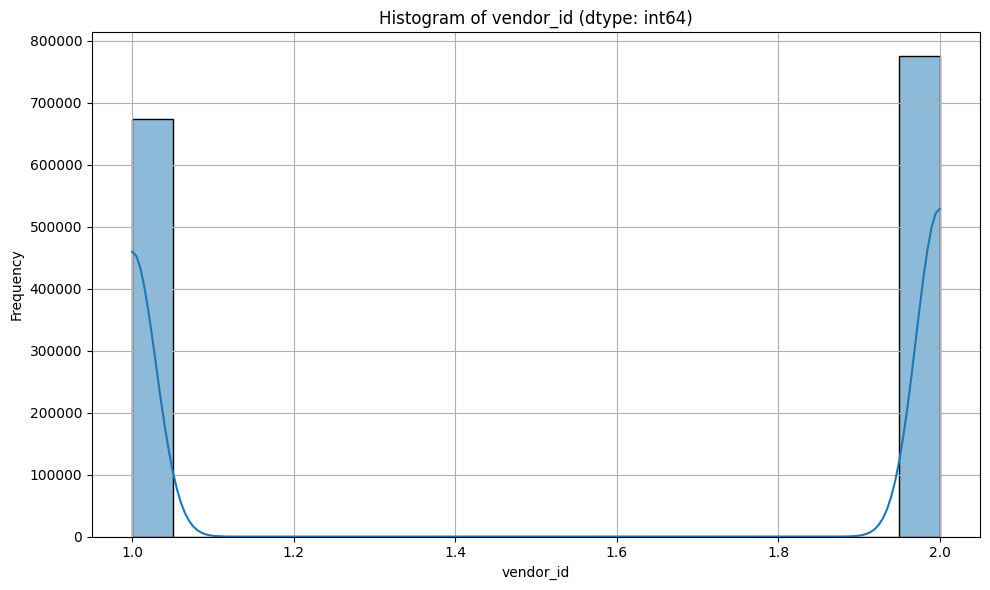

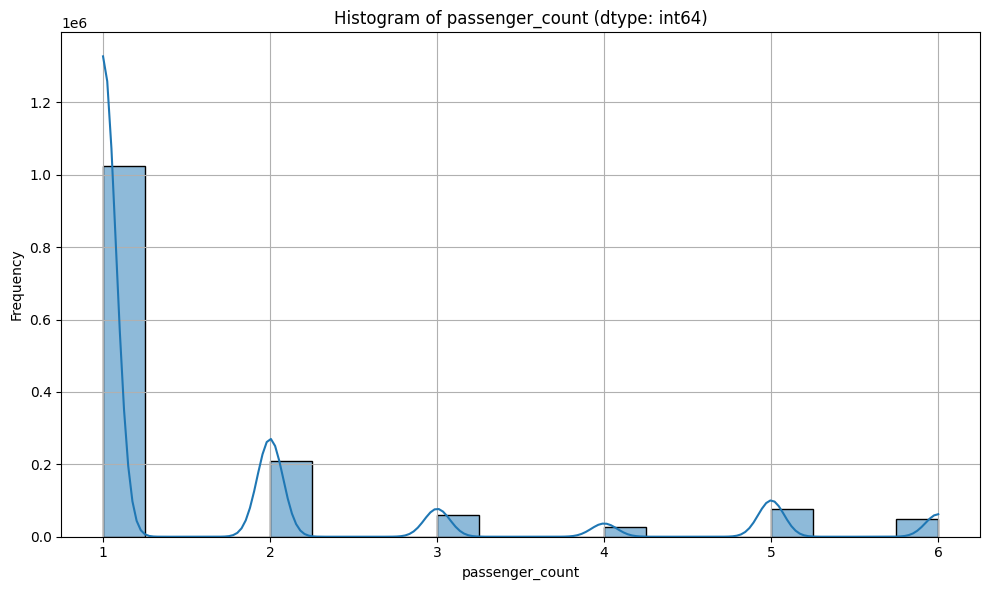

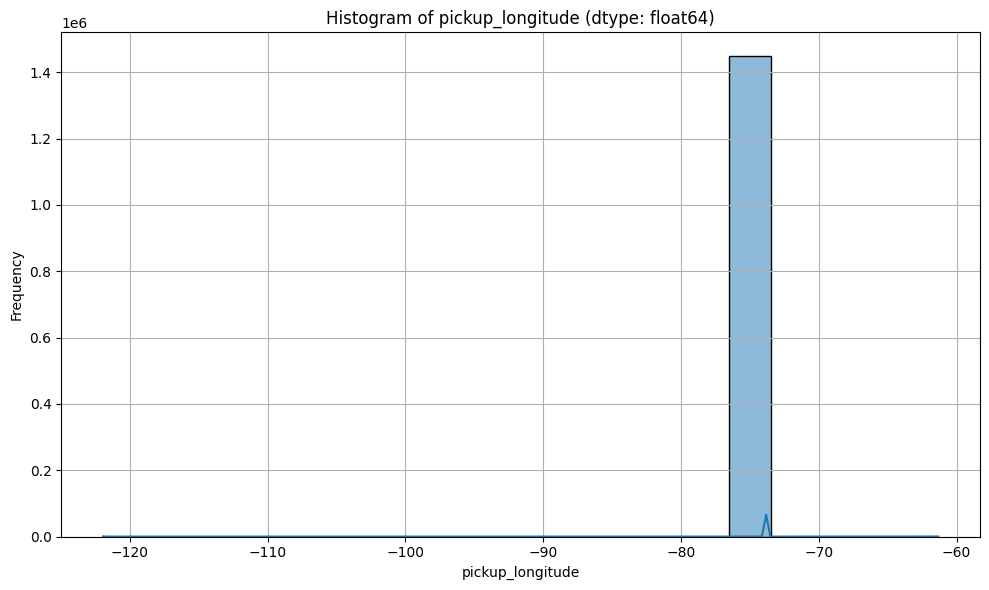

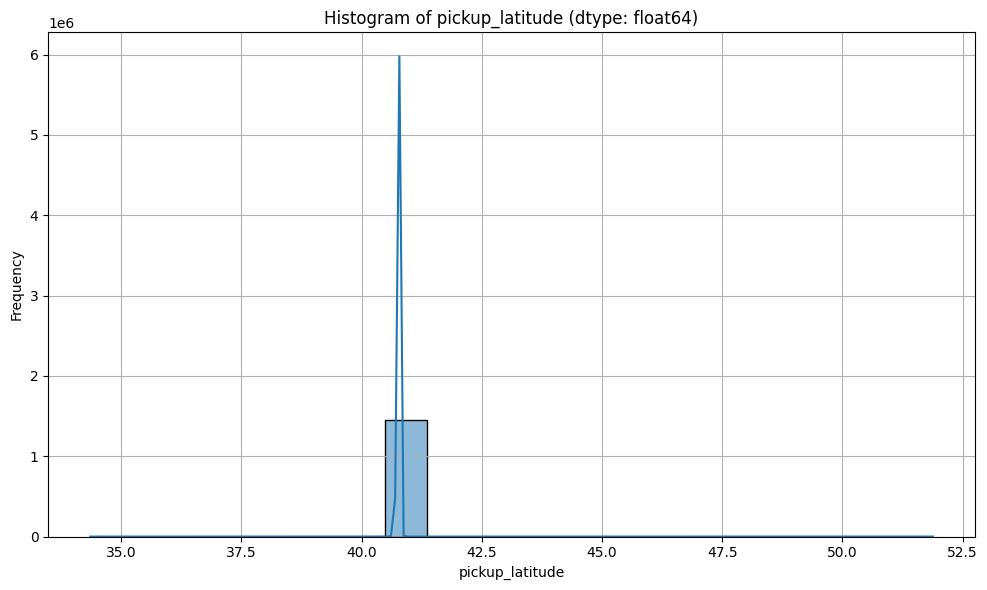

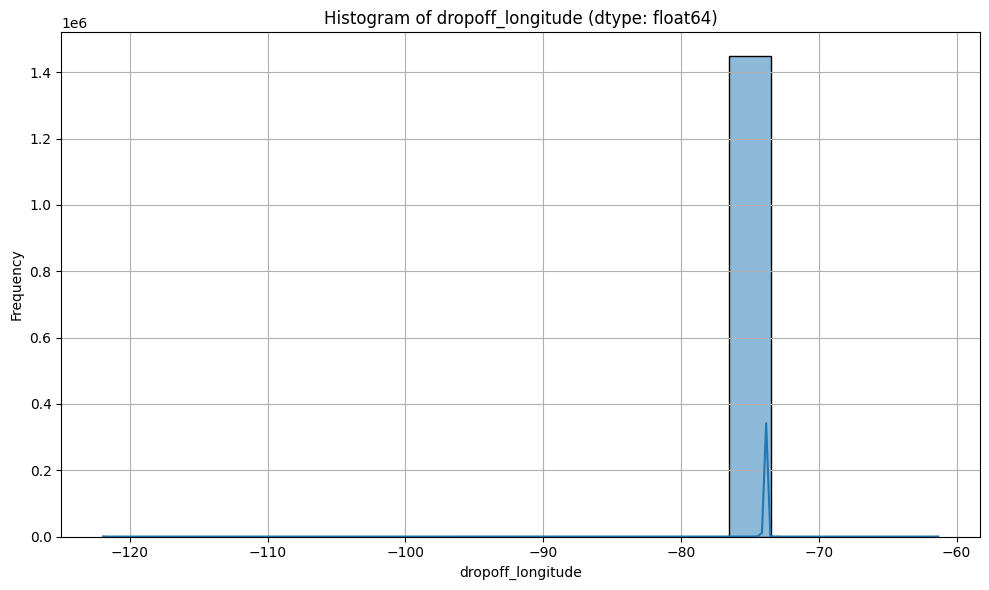

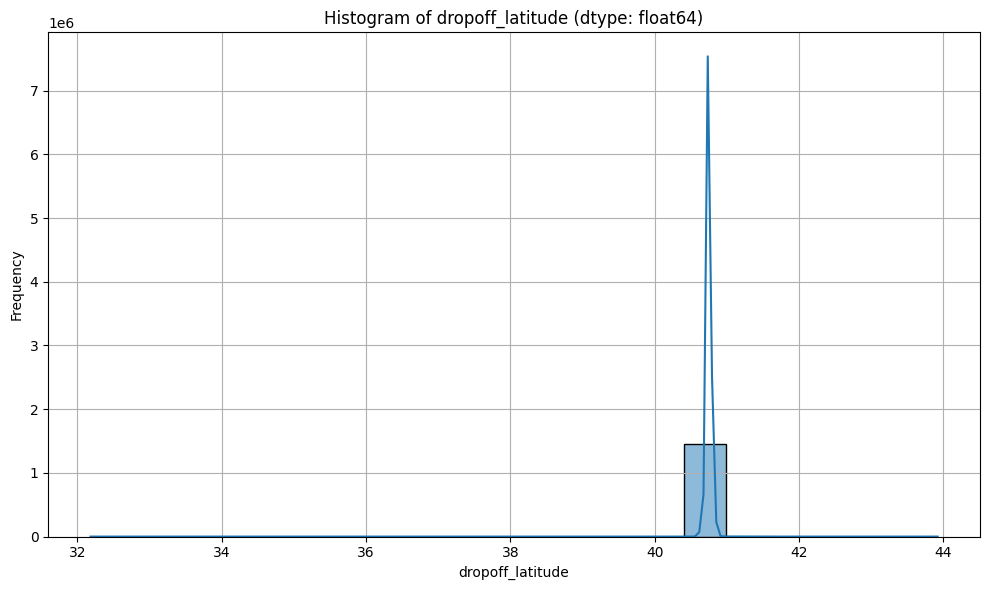

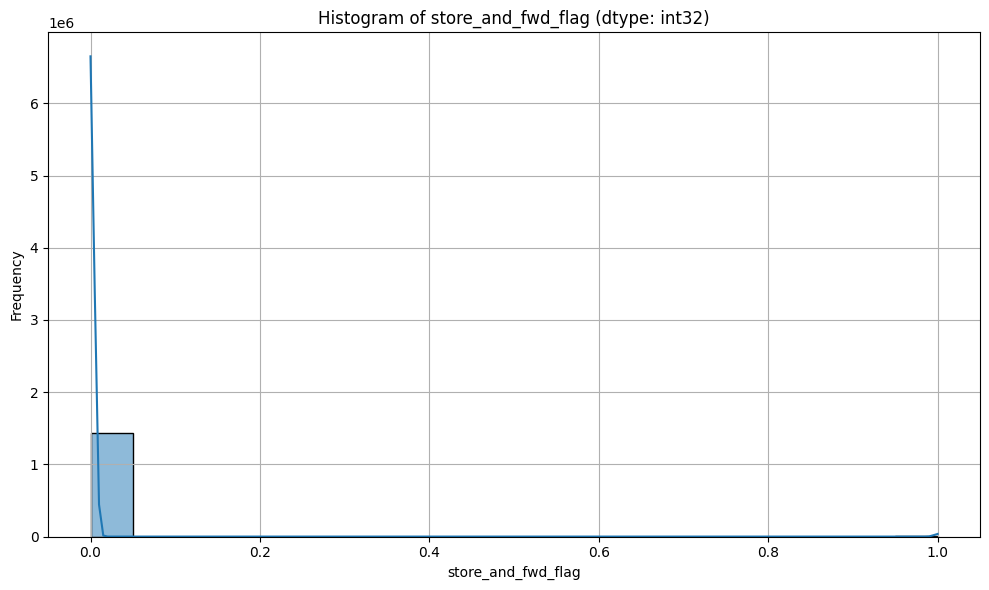

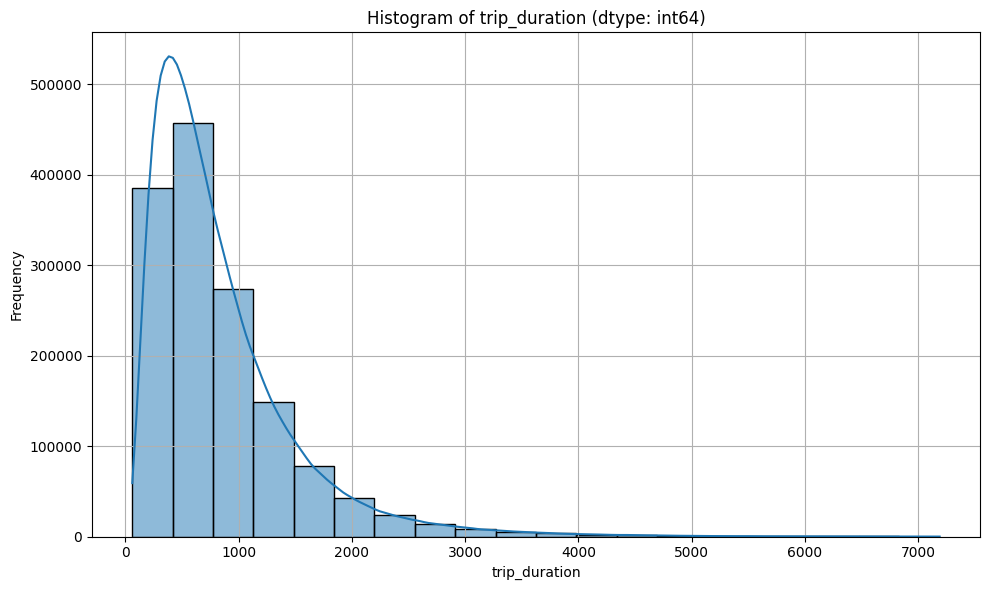

In [12]:
plot_all_histograms(df)

HISTOGRAM Analysis:

trip duration need to be transoform to logaritmic post split

store_and_fwd_flag isnt informative as its mainly N

geo location will be feature eng into clusters

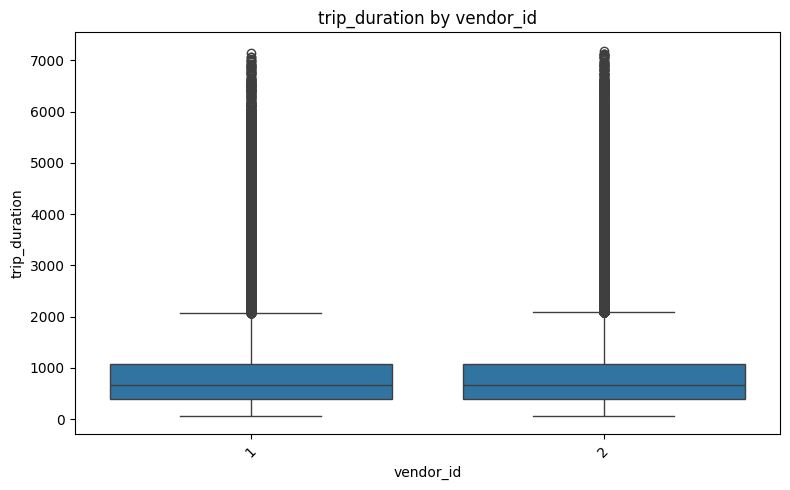

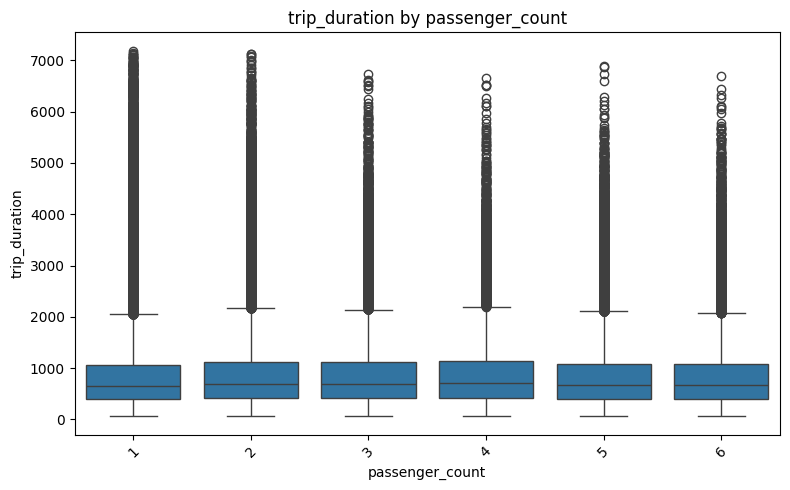

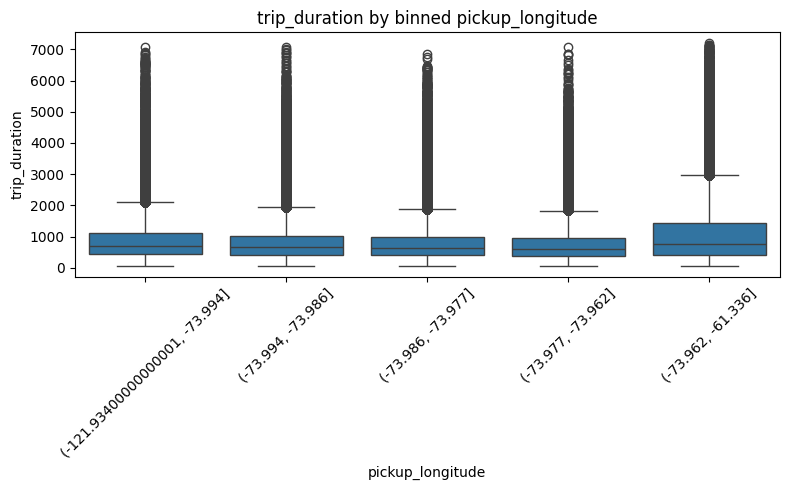

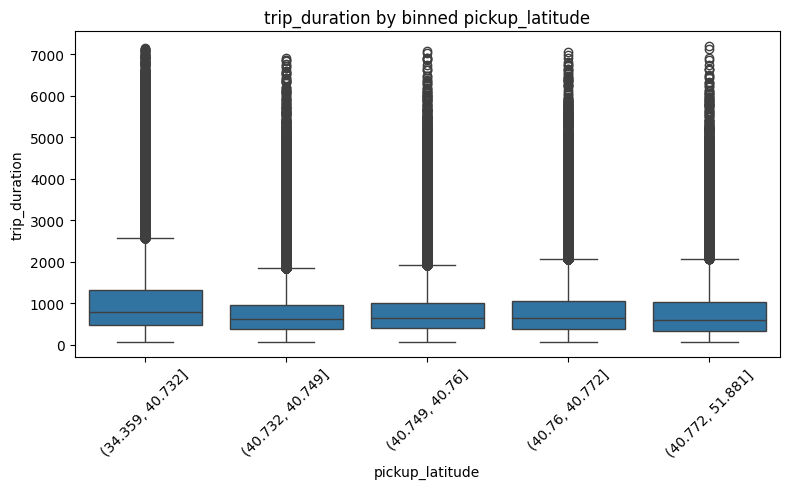

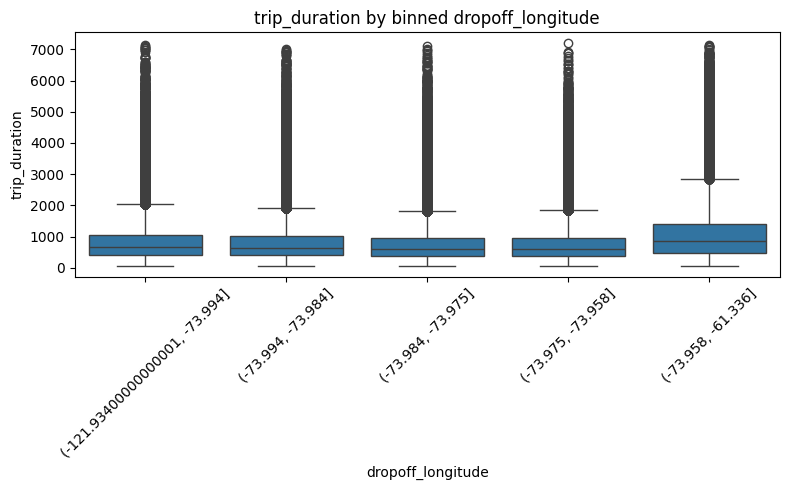

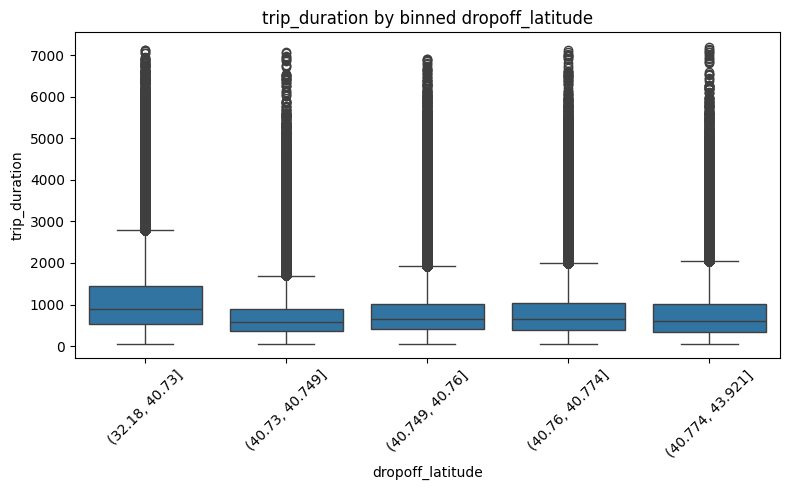

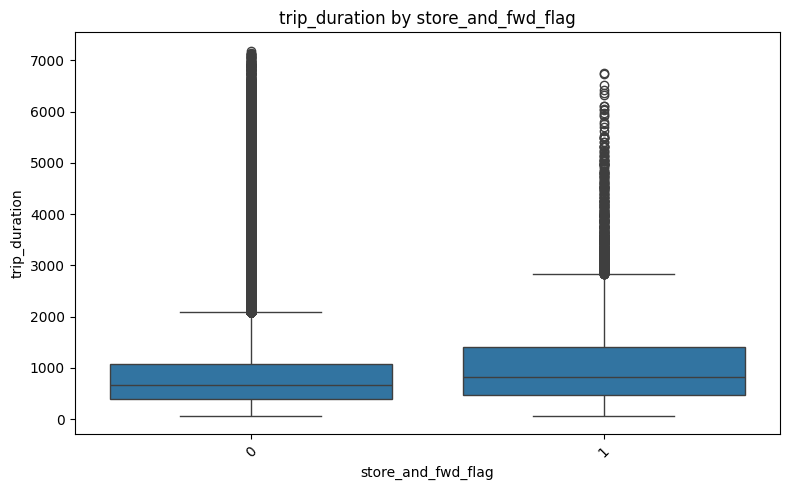

In [13]:
plot_boxplots_vs_target(df, target)

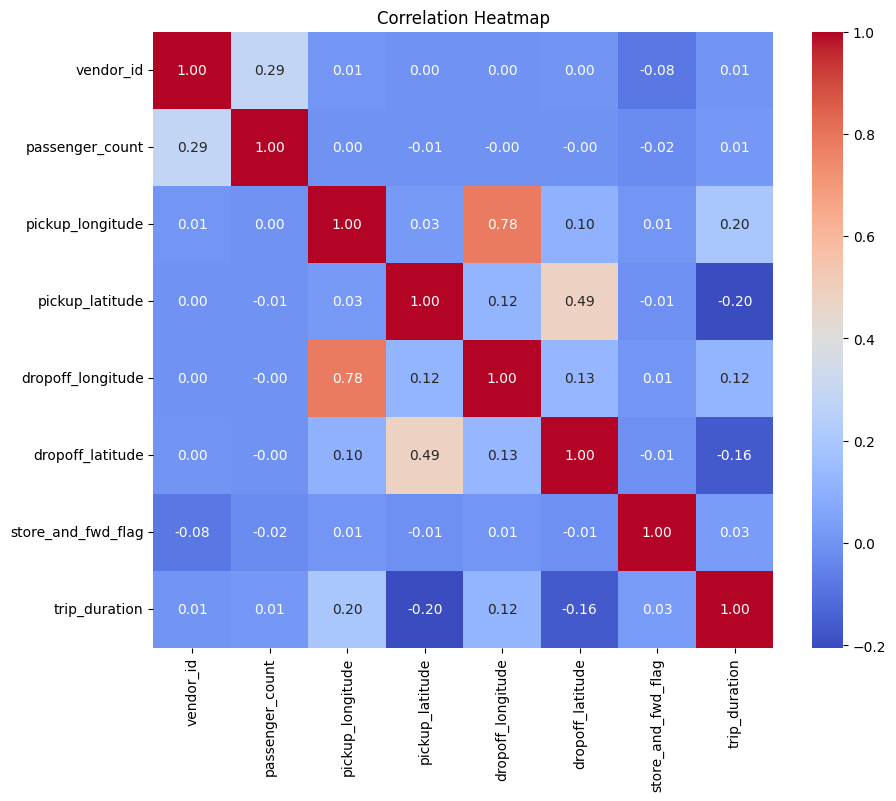

In [14]:
plot_correlation_heatmap(df)

no strong correlation between the numeric vars

only between the pickup and dropoff longitude which are almost the same which mean the location is in the same region - will feature eng to clusters

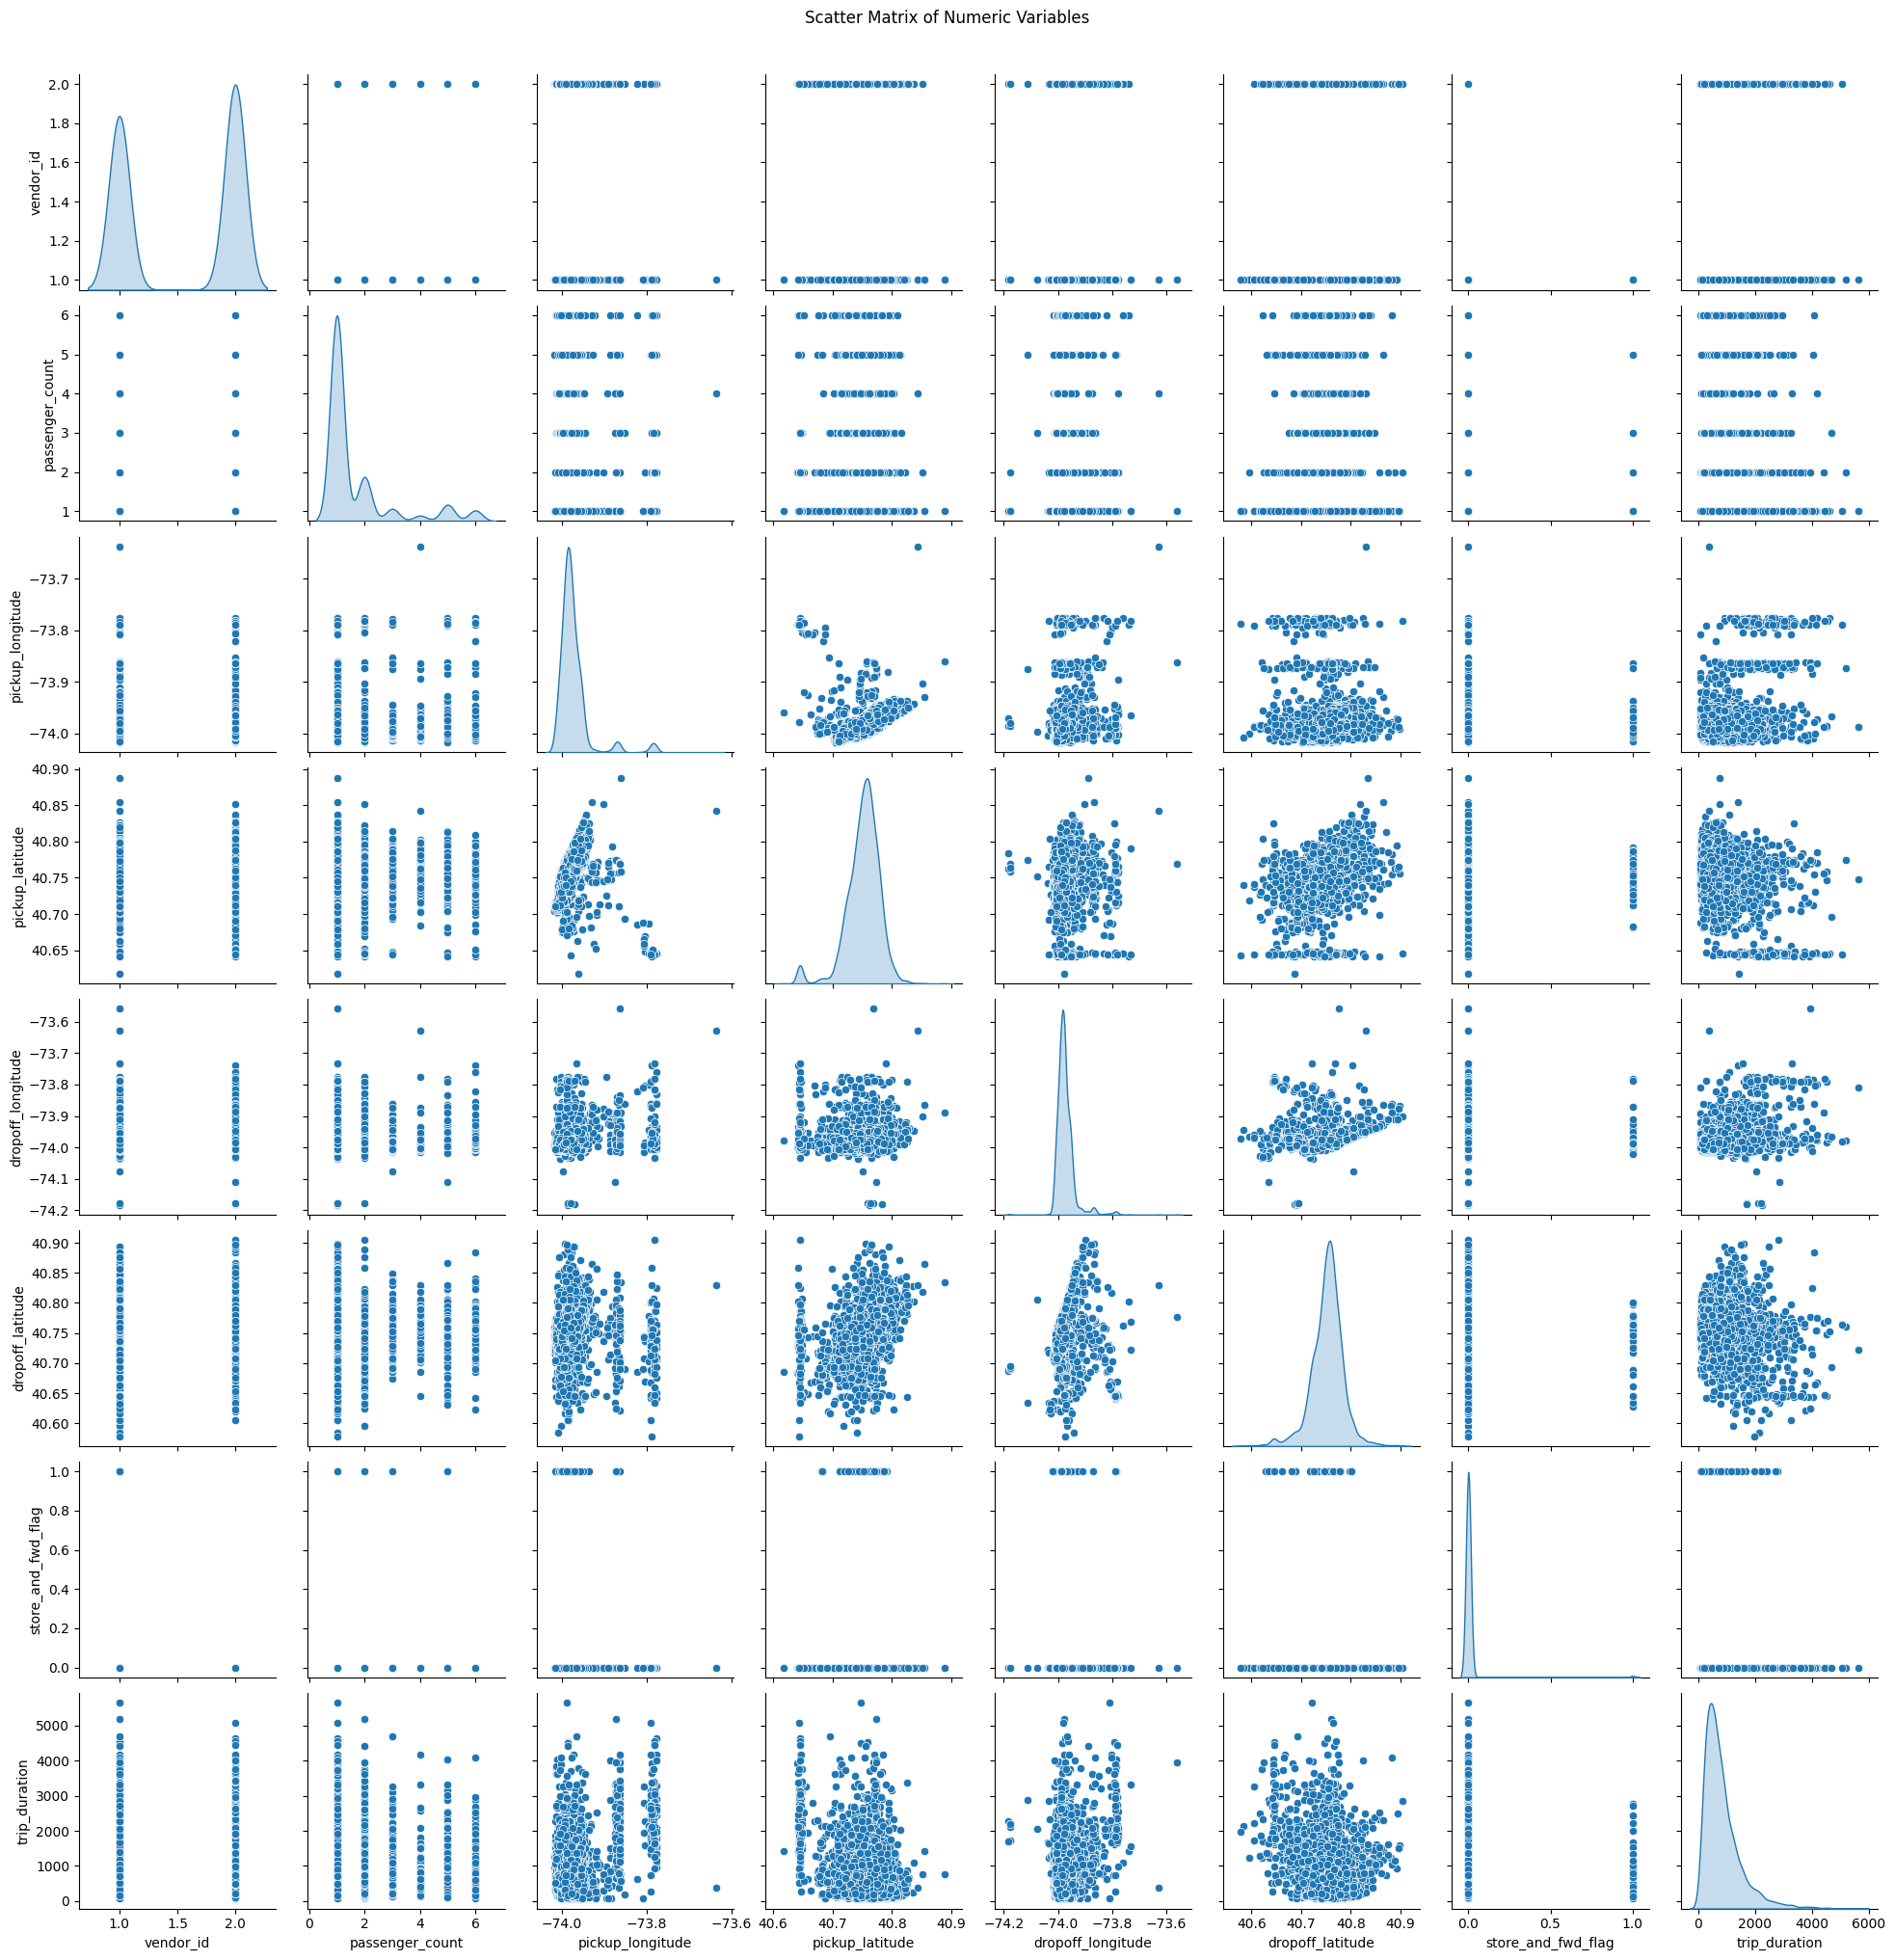

In [15]:
plot_scatter_matrix(df)

In [16]:
skew_kurtosis = analyze_skew_kurtosis(df)
display(skew_kurtosis)

,Skewness,Kurtosis,Normality,Skew Type
vendor_id,-0.14,-1.98,Not Normal,Normal Skew
passenger_count,2.13,3.42,Not Normal,Right Skew
pickup_longitude,-423.73,292573.95,Not Normal,Left Skew
pickup_latitude,5.64,13386.42,Not Normal,Right Skew
dropoff_longitude,-431.07,297052.99,Not Normal,Left Skew
dropoff_latitude,-21.14,4371.17,Not Normal,Left Skew
store_and_fwd_flag,13.42,178.15,Not Normal,Right Skew
trip_duration,2.21,7.79,Not Normal,Right Skew


all data is not normal

<h2>Feature Engineering</h2>

post several tried with low RMSE added new features

1. pickup hour
2. pickup day of week
3. pickup day of year
4. Month
5. is weekend
6. haversine distance
7. heavy hour traffic - check if the trip count in the upper25% by hour of the day
8. heavy day traffice - check if the trip count in the upper25% by day of the week
9. count trip per day anomaly - check for lower 10% days of year that can be holiday / special days

In [17]:
df = taxi_features_eng (df , 0.1)
display(df)
generate_data_statistics(df)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,pickup_day_of_year,month,is_weekend,haversine_distance,manhattan_distance,heavy_hour_traffic,heavy_day_traffic,count_trip_per_day_anomaly
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,0,455,17,1,74,3,0,1.50,1.73,1,0,0
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,0,663,0,7,164,6,1,1.81,2.43,0,0,1
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,0,2124,11,2,19,1,0,6.39,8.19,0,0,0
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,0,429,19,3,97,4,0,1.49,1.66,1,0,0
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,0,435,13,6,86,3,1,1.19,1.20,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.98,40.75,-73.99,40.74,0,778,13,5,99,4,0,1.23,1.66,0,1,0
1458640,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.00,40.75,-73.97,40.80,0,655,7,7,10,1,1,6.05,8.04,0,0,0
1458641,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.96,40.77,-74.00,40.71,0,764,6,5,113,4,0,7.82,10.63,0,1,0
1458642,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.98,40.75,-73.97,40.76,0,373,15,2,5,1,0,1.09,1.52,0,0,0


(                               Min     Max    AVG  Median   Range    STD         VAR               SUM    Count   Mode  Mode Count  Mode Percentage     5%     Q1      Q3     95%    IQR
 vendor_id                     1.00    2.00   1.54    2.00    1.00   0.50        0.25      2,222,403.00  1447777   2.00      774626            53.50   1.00   1.00    2.00    2.00   1.00
 passenger_count               1.00    6.00   1.67    1.00    5.00   1.31        1.73      2,411,053.00  1447777   1.00     1025323            70.82   1.00   1.00    2.00    5.00   1.00
 pickup_longitude           -121.93  -61.34 -73.97  -73.98   60.60   0.07        0.01   -107,097,314.15  1447777 -73.98         628             0.04 -74.01 -73.99  -73.97  -73.90   0.02
 pickup_latitude              34.36   51.88  40.75   40.75   17.52   0.03        0.00     58,998,323.52  1447777  40.77         411             0.03  40.71  40.74   40.77   40.79   0.03
 dropoff_longitude          -121.93  -61.34 -73.97  -73.98   60.60   0

In [18]:
display(df.dtypes)

vendor_id                              int64
pickup_datetime               datetime64[ns]
dropoff_datetime              datetime64[ns]
passenger_count                        int64
pickup_longitude                     float64
pickup_latitude                      float64
dropoff_longitude                    float64
dropoff_latitude                     float64
store_and_fwd_flag                     int32
trip_duration                          int64
pickup_hour                            int32
pickup_day_of_week                     int32
pickup_day_of_year                     int32
month                                  int32
is_weekend                             int64
haversine_distance                   float64
manhattan_distance                   float64
heavy_hour_traffic                     int32
heavy_day_traffic                      int32
count_trip_per_day_anomaly             int32
dtype: object

will use the haversine distance method as its VAR is lower

<h2>Clustering</h2>

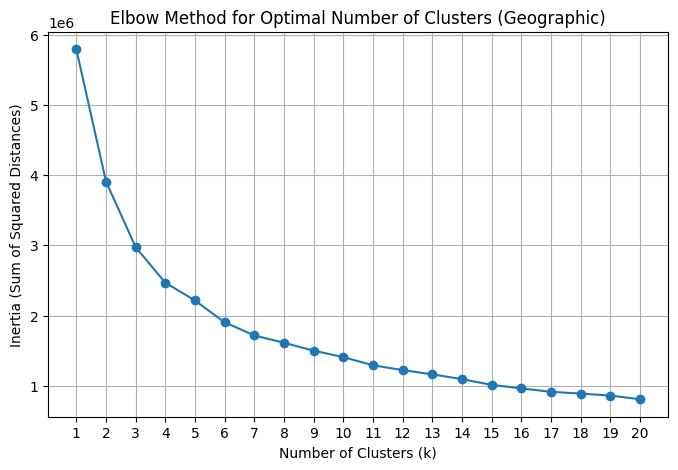

In [19]:
plot_kmeans_elbow_geo(df, features_to_cluster, max_clusters=20)

from 6 the gain isnt so big

but post few runs of 5,6,7,8 decide to take 8 as the numbers as its give more accurate to the far rides

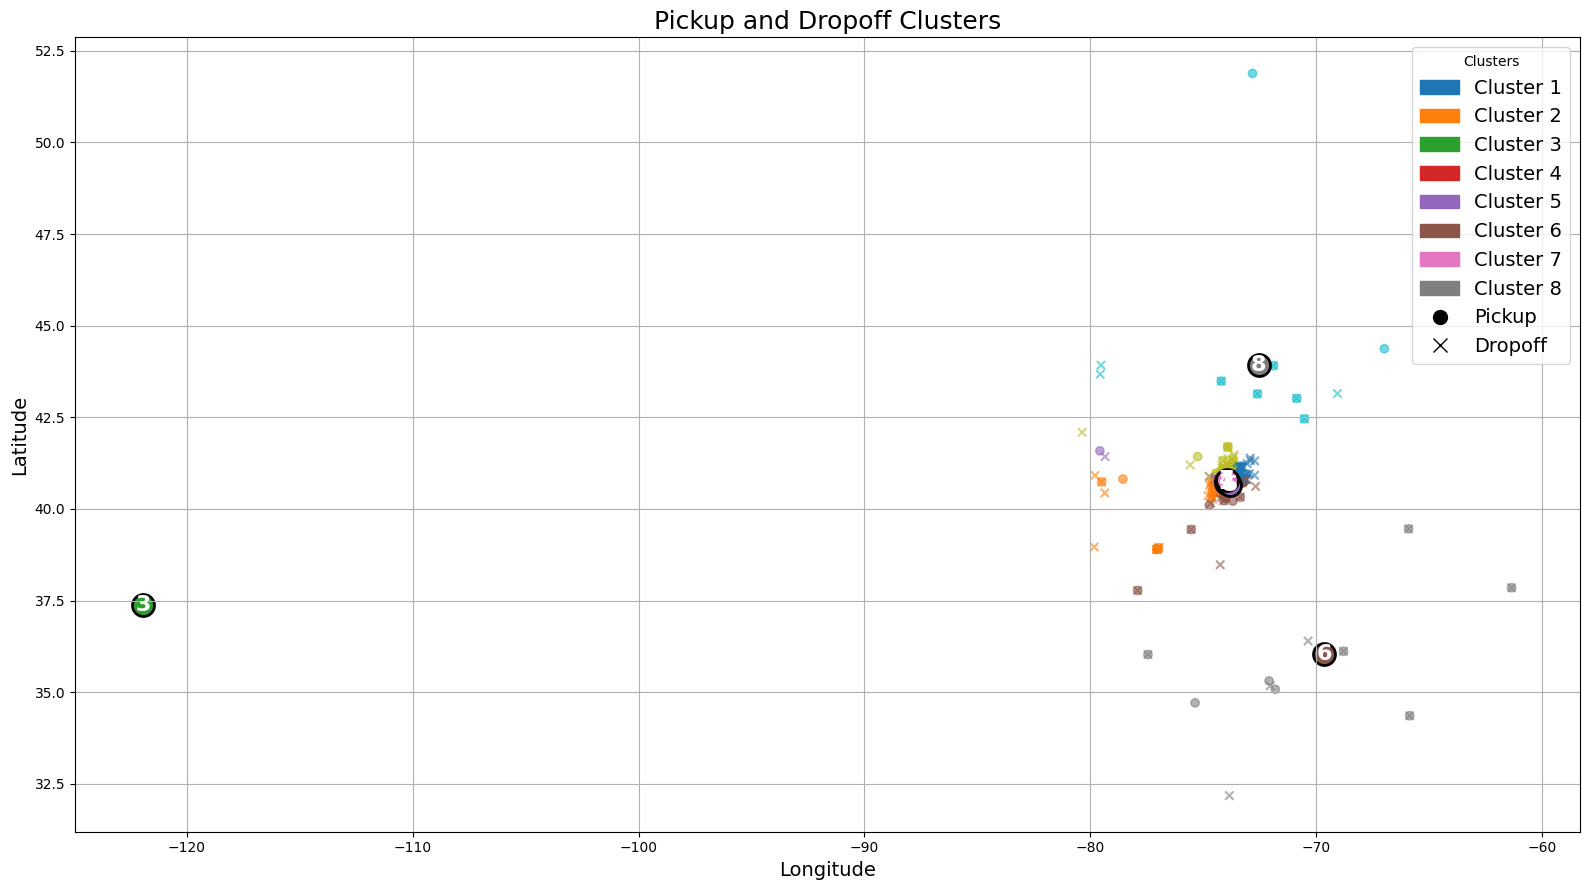

In [20]:
df, cluster_scalar, cluster_kmenas, pickup_features, dropoff_features = apply_kmeans_cluster(df, features_to_cluster, 8)

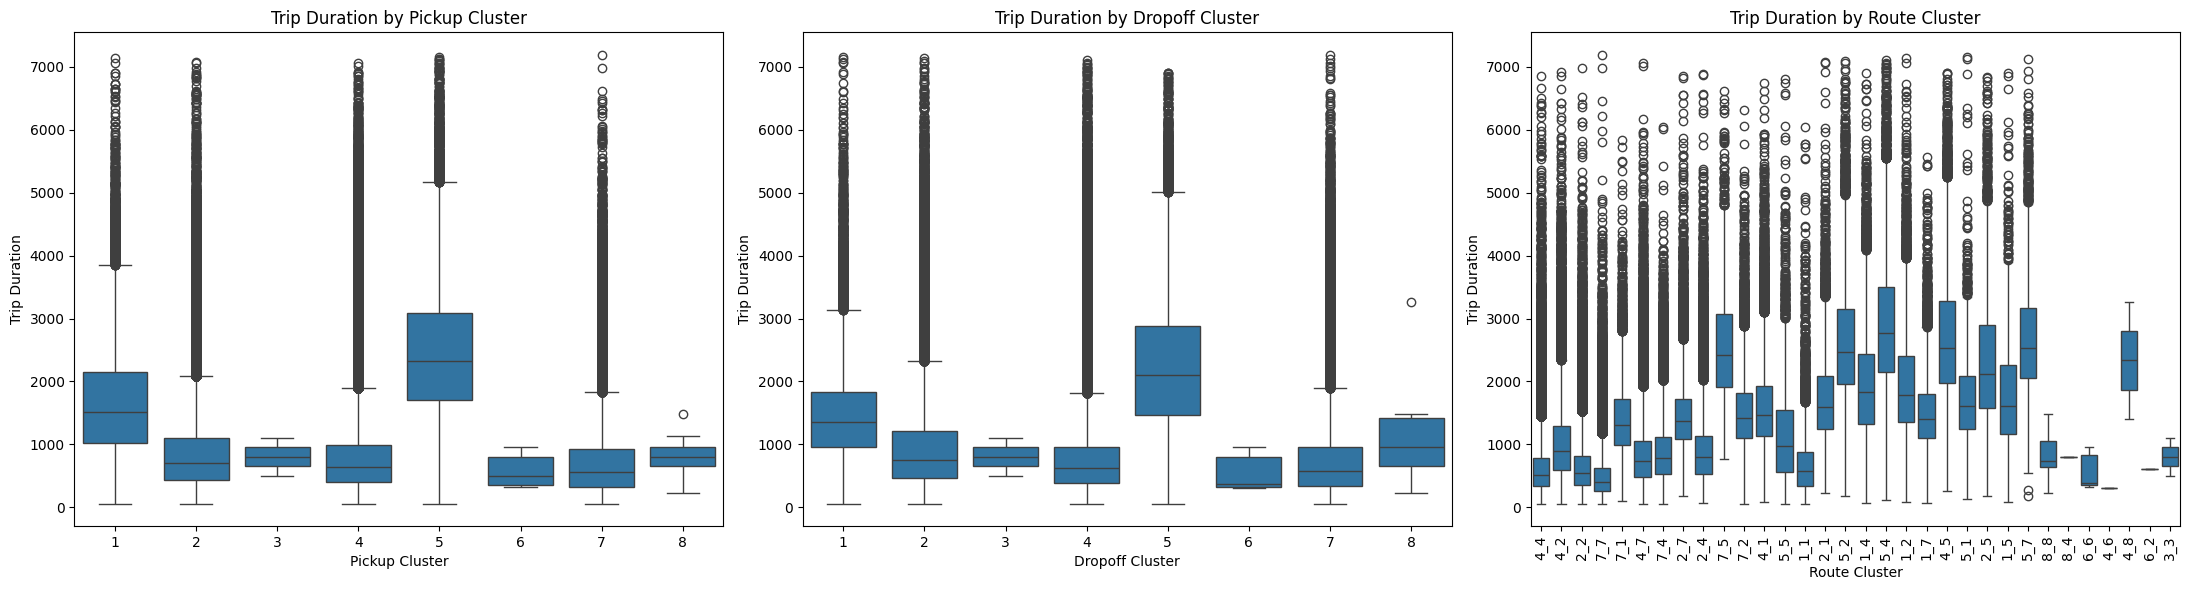

In [21]:
plot_trip_duration_by_clusters(df)

we can see that cluster 3 is very unique and ride only within

also see that cluster 8 and 6 are trip_duration is low

we can see in the plow that 3,6,8 arent in the center city whic have less traffic

will drop the route_cluster as it will get too many features in the hot encoding

In [22]:
df = df.drop(columns=['route_cluster'])

In [23]:
display(df)
display(df.dtypes)
generate_data_statistics(df)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,pickup_day_of_year,month,is_weekend,haversine_distance,manhattan_distance,heavy_hour_traffic,heavy_day_traffic,count_trip_per_day_anomaly,pickup_cluster,dropoff_cluster
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,0,455,17,1,74,3,0,1.50,1.73,1,0,0,4,4
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,0,663,0,7,164,6,1,1.81,2.43,0,0,1,4,2
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,0,2124,11,2,19,1,0,6.39,8.19,0,0,0,4,2
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,0,429,19,3,97,4,0,1.49,1.66,1,0,0,2,2
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,0,435,13,6,86,3,1,1.19,1.20,0,1,0,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.98,40.75,-73.99,40.74,0,778,13,5,99,4,0,1.23,1.66,0,1,0,4,4
1458640,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.00,40.75,-73.97,40.80,0,655,7,7,10,1,1,6.05,8.04,0,0,0,4,7
1458641,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.96,40.77,-74.00,40.71,0,764,6,5,113,4,0,7.82,10.63,0,1,0,7,2
1458642,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.98,40.75,-73.97,40.76,0,373,15,2,5,1,0,1.09,1.52,0,0,0,4,4


vendor_id                              int64
pickup_datetime               datetime64[ns]
dropoff_datetime              datetime64[ns]
passenger_count                        int64
pickup_longitude                     float64
pickup_latitude                      float64
dropoff_longitude                    float64
dropoff_latitude                     float64
store_and_fwd_flag                     int32
trip_duration                          int64
pickup_hour                            int32
pickup_day_of_week                     int32
pickup_day_of_year                     int32
month                                  int32
is_weekend                             int64
haversine_distance                   float64
manhattan_distance                   float64
heavy_hour_traffic                     int32
heavy_day_traffic                      int32
count_trip_per_day_anomaly             int32
pickup_cluster                         int32
dropoff_cluster                        int32
dtype: obj

(                               Min     Max    AVG  Median   Range    STD         VAR               SUM    Count   Mode  Mode Count  Mode Percentage     5%     Q1      Q3     95%    IQR
 vendor_id                     1.00    2.00   1.54    2.00    1.00   0.50        0.25      2,222,403.00  1447777   2.00      774626            53.50   1.00   1.00    2.00    2.00   1.00
 passenger_count               1.00    6.00   1.67    1.00    5.00   1.31        1.73      2,411,053.00  1447777   1.00     1025323            70.82   1.00   1.00    2.00    5.00   1.00
 pickup_longitude           -121.93  -61.34 -73.97  -73.98   60.60   0.07        0.01   -107,097,314.15  1447777 -73.98         628             0.04 -74.01 -73.99  -73.97  -73.90   0.02
 pickup_latitude              34.36   51.88  40.75   40.75   17.52   0.03        0.00     58,998,323.52  1447777  40.77         411             0.03  40.71  40.74   40.77   40.79   0.03
 dropoff_longitude          -121.93  -61.34 -73.97  -73.98   60.60   0

<h2> Transform </h2>

trip_duration trasnfrom into logaritmic

In [24]:
df = log_transform_column(df, 'trip_duration')

In [25]:
generate_data_statistics(df)

(                               Min     Max    AVG  Median   Range   STD       VAR              SUM    Count   Mode  Mode Count  Mode Percentage     5%     Q1     Q3    95%   IQR
 vendor_id                     1.00    2.00   1.54    2.00    1.00  0.50      0.25     2,222,403.00  1447777   2.00      774626            53.50   1.00   1.00   2.00   2.00  1.00
 passenger_count               1.00    6.00   1.67    1.00    5.00  1.31      1.73     2,411,053.00  1447777   1.00     1025323            70.82   1.00   1.00   2.00   5.00  1.00
 pickup_longitude           -121.93  -61.34 -73.97  -73.98   60.60  0.07      0.01  -107,097,314.15  1447777 -73.98         628             0.04 -74.01 -73.99 -73.97 -73.90  0.02
 pickup_latitude              34.36   51.88  40.75   40.75   17.52  0.03      0.00    58,998,323.52  1447777  40.77         411             0.03  40.71  40.74  40.77  40.79  0.03
 dropoff_longitude          -121.93  -61.34 -73.97  -73.98   60.60  0.07      0.00  -107,097,197.42  1447

<h2>Anomality Detection and outliers</h2>

will will isolation forest as my data isnt normal distributed only for the features i pllaned to run my model on

In [26]:
df, iso_model, iso_model_features = detect_anomalies_isolation_forest(df , 0.01, features)
joblib.dump(iso_model, 'iso_forest_model.joblib')
joblib.dump(iso_model_features, 'features_to_use.pkl')

Detected 14478 anomalies out of 1447777 rows. (1.00%)

Top features contributing to anomalies (by median deviation):
haversine_distance           9.28
month                        2.13
passenger_count              2.05
pickup_cluster               1.89
pickup_hour                  1.33
pickup_day_of_week           1.32
dropoff_cluster              1.02
count_trip_per_day_anomaly   0.87
heavy_hour_traffic           0.44
vendor_id                    0.36
dtype: float64


['features_to_use.pkl']

In [27]:
display(df)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,pickup_day_of_year,month,is_weekend,haversine_distance,manhattan_distance,heavy_hour_traffic,heavy_day_traffic,count_trip_per_day_anomaly,pickup_cluster,dropoff_cluster,anomaly
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,0,6.12,17,1,74,3,0,1.50,1.73,1,0,0,4,4,0
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,0,6.50,0,7,164,6,1,1.81,2.43,0,0,1,4,2,0
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,0,7.66,11,2,19,1,0,6.39,8.19,0,0,0,4,2,0
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,0,6.06,19,3,97,4,0,1.49,1.66,1,0,0,2,2,0
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,0,6.08,13,6,86,3,1,1.19,1.20,0,1,0,7,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.98,40.75,-73.99,40.74,0,6.66,13,5,99,4,0,1.23,1.66,0,1,0,4,4,0
1458640,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.00,40.75,-73.97,40.80,0,6.49,7,7,10,1,1,6.05,8.04,0,0,0,4,7,0
1458641,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.96,40.77,-74.00,40.71,0,6.64,6,5,113,4,0,7.82,10.63,0,1,0,7,2,0
1458642,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.98,40.75,-73.97,40.76,0,5.92,15,2,5,1,0,1.09,1.52,0,0,0,4,4,0


In [28]:
#add to features the anomaly col
features.append('anomaly')


In [29]:
display(features)

['vendor_id',
 'passenger_count',
 'pickup_hour',
 'pickup_day_of_week',
 'month',
 'store_and_fwd_flag',
 'haversine_distance',
 'heavy_hour_traffic',
 'heavy_day_traffic',
 'count_trip_per_day_anomaly',
 'pickup_cluster',
 'dropoff_cluster',
 'anomaly']

recheck the numeric correlation post all eng features

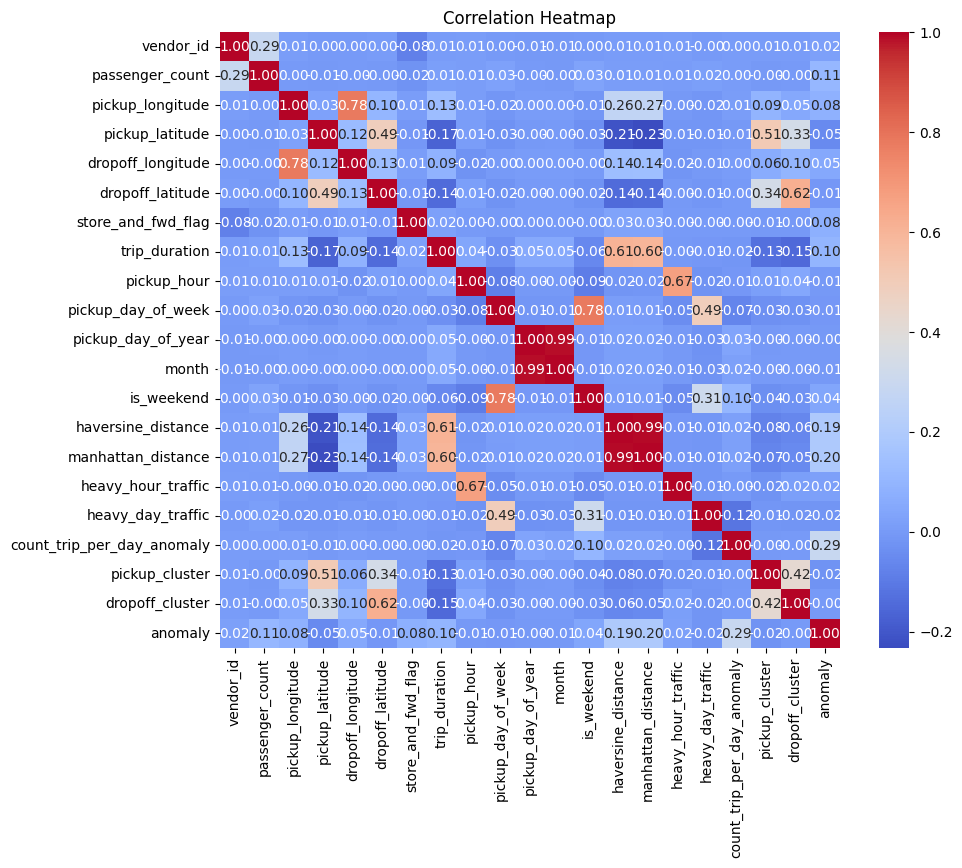

In [30]:
plot_correlation_heatmap(df)

will remoe the following features from feature list as they are too correlative

is_weekend correalted to day_of_week

pickup day of year correlated to the month

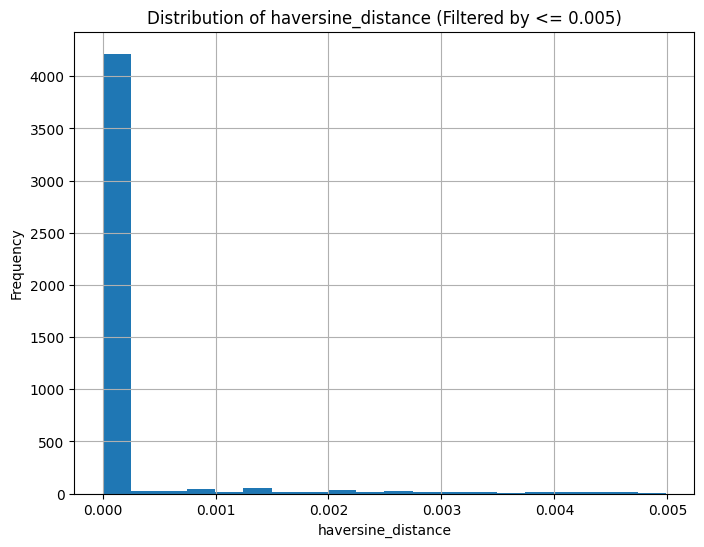

In [31]:
plot_histogram_filtered(df,'haversine_distance', '<=', 0.005)

In [32]:
#delete all trips less than 50m values in the haersine_distance
display(df.shape)
df = df[df['haversine_distance'] > 0.05]
display(df.shape)

(1447777, 23)

(1441565, 23)

<h2>Spit data into train/test</h2>

In [33]:
X_train, y_train, X_test, y_test = split_features_target(df, features, target, 0.2, magic_num)

In [34]:
display(X_train)

,vendor_id,passenger_count,pickup_hour,pickup_day_of_week,month,store_and_fwd_flag,haversine_distance,heavy_hour_traffic,heavy_day_traffic,count_trip_per_day_anomaly,pickup_cluster,dropoff_cluster,anomaly
215576,2,1,11,4,6,0,0.90,0,0,0,4,7,0
690401,1,1,23,5,5,0,9.60,0,1,0,4,7,0
506330,1,1,19,1,1,0,5.85,1,0,0,2,4,0
554349,2,1,5,2,6,0,1.21,0,0,0,4,4,0
435706,2,1,23,7,1,0,0.66,0,0,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262234,2,1,1,1,1,0,6.55,0,0,1,2,4,0
1431187,2,1,5,5,6,0,4.91,0,1,0,4,7,0
133486,1,1,10,4,6,1,1.75,0,0,0,2,2,0
679146,1,2,19,7,6,0,1.36,1,0,0,2,2,0


In [35]:
display(y_train)

215576    5.93
690401    7.51
506330    6.67
554349    5.61
435706    5.30
          ... 
262234    7.22
1431187   6.71
133486    6.69
679146    6.44
123395    6.39
Name: trip_duration, Length: 1153252, dtype: float64

In [36]:
generate_data_statistics(X_train)

(                            Min     Max   AVG  Median   Range  STD    VAR            SUM    Count  Mode  Mode Count  Mode Percentage   5%   Q1    Q3   95%   IQR
 vendor_id                  1.00    2.00  1.53    2.00    1.00 0.50   0.25   1,769,374.00  1153252  2.00      616122            53.42 1.00 1.00  2.00  2.00  1.00
 passenger_count            1.00    6.00  1.67    1.00    5.00 1.32   1.73   1,921,127.00  1153252  1.00      816676            70.82 1.00 1.00  2.00  5.00  1.00
 pickup_hour                0.00   23.00 13.61   14.00   23.00 6.40  40.92  15,701,412.00  1153252 18.00       71837             6.23 1.00 9.00 19.00 22.00 10.00
 pickup_day_of_week         1.00    7.00  4.05    4.00    6.00 1.95   3.82   4,668,486.00  1153252  5.00      176675            15.32 1.00 2.00  6.00  7.00  4.00
 month                      1.00    6.00  3.52    4.00    5.00 1.68   2.83   4,055,550.00  1153252  3.00      202585            17.57 1.00 2.00  5.00  6.00  3.00
 store_and_fwd_flag         

<H2> Test Models </h2
>

<h3> Liniar Regression </h3>

MSE: 0.3177
RMSE: 0.5637
MAE: 0.4250
R^2: 0.3996
Adjusted R^2: 0.3996
Residuals Mean: -0.0001
Residuals Std Dev: 0.5637
Residuals Skewness: -7.0745
Percentage predictions within 10% error: 79.00%


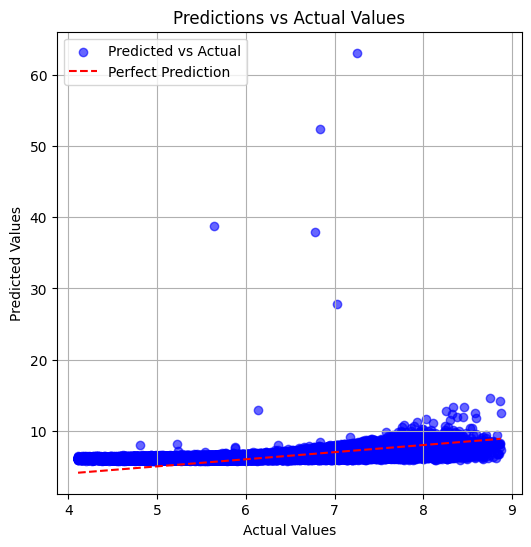

In [37]:
model_lr = LinearRegression()

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),  # Standardize numerical features
    ('model', model_lr)
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

error_analysis(y_test, y_pred_lr, X_test.shape[1])

<h3>Gradient Boosting Regressor</h3>

MSE: 0.1445
RMSE: 0.3801
MAE: 0.2891
R^2: 0.7270
Adjusted R^2: 0.7270
Residuals Mean: -0.0007
Residuals Std Dev: 0.3801
Residuals Skewness: 0.1402
Percentage predictions within 10% error: 90.40%


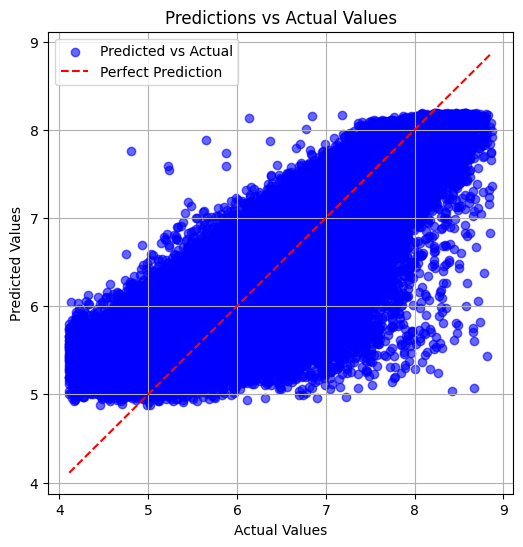

In [38]:
model_gbm = GradientBoostingRegressor(
    n_estimators=100,    # you can tune this
    learning_rate=0.1,   # you can tune this
    max_depth=3,         # you can tune this
    random_state=magic_num
)

pipeline_gbm = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_gbm)
])

pipeline_gbm.fit(X_train, y_train)
y_pred_gbm = pipeline_gbm.predict(X_test)

error_analysis(y_test, y_pred_gbm, X_test.shape[1])

<h3>Decision Tree Regressor </h3>

MSE: 0.1450
RMSE: 0.3807
MAE: 0.2887
R^2: 0.7261
Adjusted R^2: 0.7261
Residuals Mean: -0.0008
Residuals Std Dev: 0.3807
Residuals Skewness: 0.1425
Percentage predictions within 10% error: 90.35%


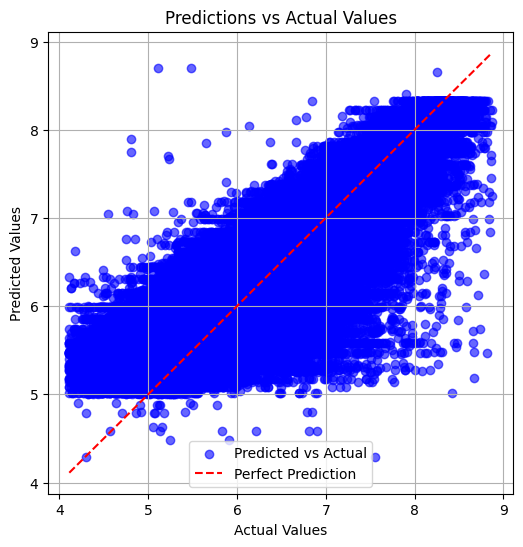

In [39]:
model_dtr = DecisionTreeRegressor(
    max_depth=10,      # You can tune this parameter
    random_state=magic_num
)

pipeline_dtr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_dtr)
])

pipeline_dtr.fit(X_train, y_train)
y_pred_dtr = pipeline_dtr.predict(X_test)

error_analysis(y_test, y_pred_dtr, X_test.shape[1])

<h3> Random Forest</h3>

MSE: 0.1505
RMSE: 0.3879
MAE: 0.2927
R^2: 0.7157
Adjusted R^2: 0.7157
Residuals Mean: -0.0016
Residuals Std Dev: 0.3879
Residuals Skewness: 0.0945
Percentage predictions within 10% error: 89.76%


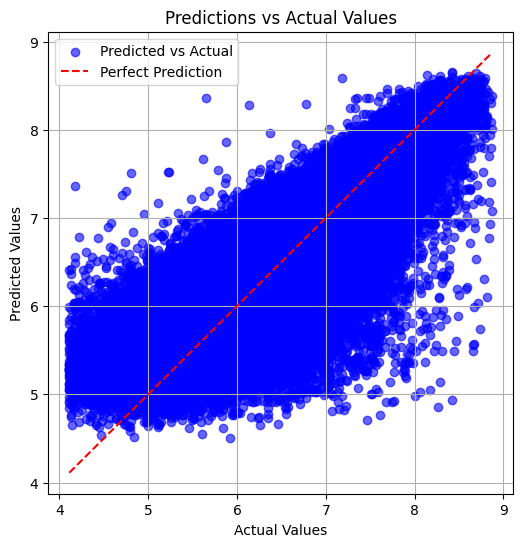

In [40]:
model_rf = RandomForestRegressor(
    n_estimators=100,    # Number of trees, can be tuned
    max_depth=None,      # Can tune or leave as None
    random_state=magic_num,
    n_jobs=-1            # Use all cores for faster training
)

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_rf)
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

error_analysis(y_test, y_pred_rf, X_test.shape[1])

<h3>Bagging Regressor</h3>

 [WinError 1450] Insufficient system resources exist to complete the requested service

In [41]:
# # Initialize the scaler and model
# scaler = StandardScaler()
# model_BR = BaggingRegressor(
#     n_estimators=100,
#     random_state=magic_num,
#     n_jobs=-1
# )

# # Scale the training data
# X_train_scaled = scaler.fit_transform(X_train)

# # Fit the model on scaled data
# model_BR.fit(X_train_scaled, y_train)

# # Scale the test data
# X_test_scaled = scaler.transform(X_test)

# # Predict on scaled test data
# y_pred_BR = model_BR.predict(X_test_scaled)

# # Perform error analysis
# error_analysis(y_test, y_pred_BR, X_test.shape[1])

<h3>XGBoost</h3>

MSE: 0.1358
RMSE: 0.3685
MAE: 0.2781
R^2: 0.7433
Adjusted R^2: 0.7433
Residuals Mean: -0.0008
Residuals Std Dev: 0.3685
Residuals Skewness: 0.1439
Percentage predictions within 10% error: 91.03%


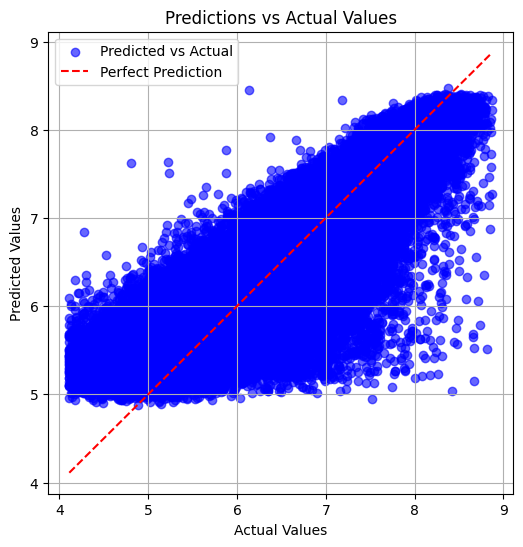

In [42]:
model_xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=magic_num,
    n_jobs=-1
)

model_xgbr.fit(X_train, y_train)
y_pred_xgbr = model_xgbr.predict(X_test)

error_analysis(y_test, y_pred_xgbr, X_test.shape[1])

<h3>Light GBM</h3>

c:\Program Files\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 1153252, number of used features: 13
[LightGBM] [Info] Start training from score 6.481842


c:\Program Files\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE: 0.1363
RMSE: 0.3692
MAE: 0.2787
R^2: 0.7424
Adjusted R^2: 0.7424
Residuals Mean: -0.0009
Residuals Std Dev: 0.3692
Residuals Skewness: 0.1576
Percentage predictions within 10% error: 90.99%


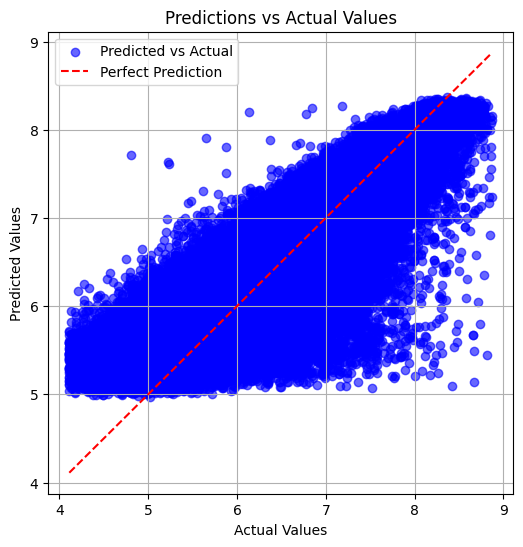

In [43]:
model_lgb = LGBMRegressor(random_state=magic_num)
pipeline_lgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_lgb)
])
pipeline_lgb.fit(X_train, y_train)
y_pred_lgb = pipeline_lgb.predict(X_test)
error_analysis(y_test, y_pred_lgb, X_test.shape[1])

<h3>Extra Trees</h3>

MSE: 0.1765
RMSE: 0.4201
MAE: 0.3168
R^2: 0.6665
Adjusted R^2: 0.6665
Residuals Mean: -0.0009
Residuals Std Dev: 0.4201
Residuals Skewness: 0.0610
Percentage predictions within 10% error: 87.61%


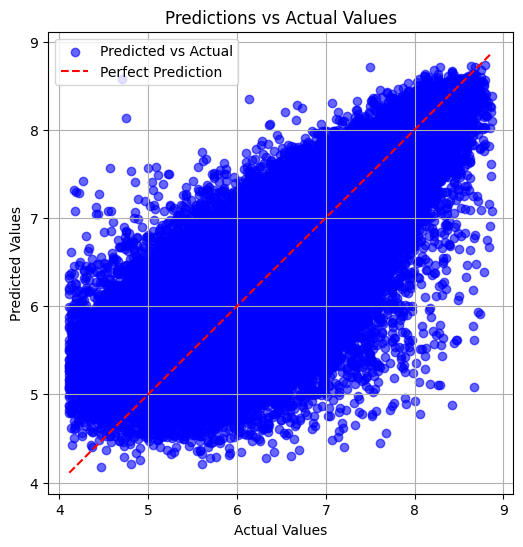

In [44]:
model_et = ExtraTreesRegressor(n_estimators=100, random_state=magic_num, n_jobs=-1)
pipeline_et = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_et)
])
pipeline_et.fit(X_train, y_train)
y_pred_et = pipeline_et.predict(X_test)
error_analysis(y_test, y_pred_et, X_test.shape[1])

<h3> TabNet - deep learning </h3>

used lartge batch size and large virtual size as in lower need gpu

c:\Program Files\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
c:\Program Files\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.76871 |  0:00:27s
epoch 1  | loss: 0.17345 |  0:00:53s
epoch 2  | loss: 0.16351 |  0:01:20s
epoch 3  | loss: 0.15899 |  0:01:46s
epoch 4  | loss: 0.15834 |  0:02:15s
epoch 5  | loss: 0.15532 |  0:02:48s
epoch 6  | loss: 0.15486 |  0:03:19s
epoch 7  | loss: 0.1539  |  0:03:50s
epoch 8  | loss: 0.15263 |  0:04:21s
epoch 9  | loss: 0.15153 |  0:04:53s
MSE: 0.1494
RMSE: 0.3866
MAE: 0.2938
R^2: 0.7176
Adjusted R^2: 0.7176
Residuals Mean: -0.0143
Residuals Std Dev: 0.3863
Residuals Skewness: 0.0742
Percentage predictions within 10% error: 89.90%


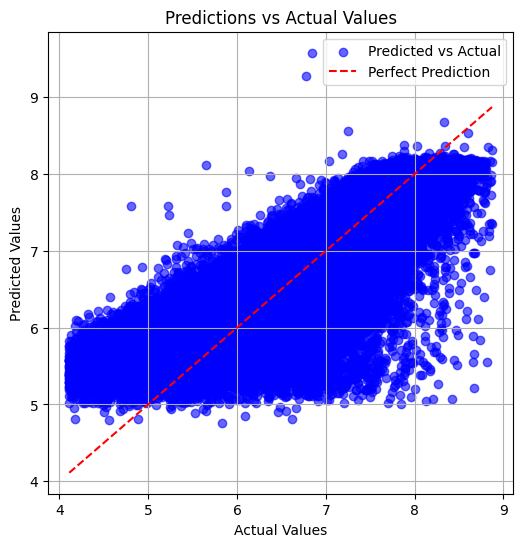

In [45]:
X_train_np, y_train_np = X_train.values, y_train.values.reshape(-1, 1)
X_test_np, y_test_np = X_test.values, y_test.values.reshape(-1, 1)

model_tabnet = TabNetRegressor()
model_tabnet.fit(
    X_train_np, y_train_np,
    max_epochs=10,
    patience=5,
    batch_size=8192,
    virtual_batch_size=1024
)
y_pred_tabnet = model_tabnet.predict(X_test_np).flatten()
error_analysis(y_test_np.flatten(), y_pred_tabnet, X_test.shape[1])

<h3> Keras Regressor - Deep Learning </h3>

adjusted the code to support CPU and early stop by lower epochs and lowe model complexity

c:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE: 0.1425
RMSE: 0.3775
MAE: 0.2837
R^2: 0.7307
Adjusted R^2: 0.7307
Residuals Mean: -0.0240
Residuals Std Dev: 0.3767
Residuals Skewness: -0.1522
Percentage predictions within 10% error: 90.60%


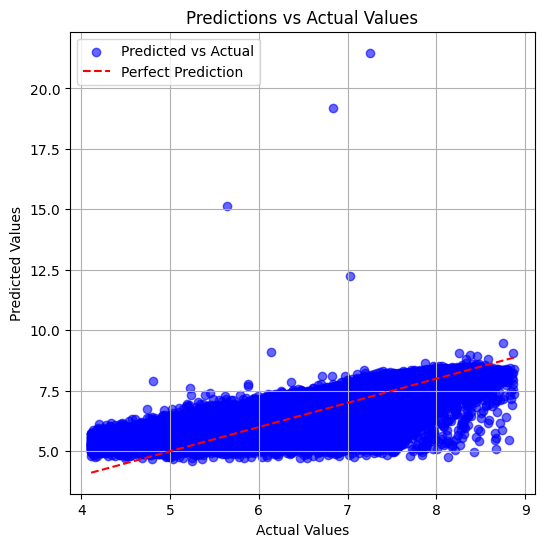

In [46]:
def build_keras_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Prepare data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
model_keras = KerasRegressor(
    model=build_keras_model,
    epochs=50,
    batch_size=256,
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    validation_split=0.1
)

model_keras.fit(X_train_scaled, y_train)
y_pred_keras = model_keras.predict(X_test_scaled)

error_analysis(y_test, y_pred_keras, X_test.shape[1])


## 📌 Summary & Conclusions

The Kaggle dataset used in this regression problem was particularly challenging. Even among other participants, the best observed $R^2$ scores typically ranged between **0.5 and 0.7**. Therefore, achieving an $R^2$ in that ballpark can be considered reasonably strong for this dataset — although additional data could significantly enhance prediction accuracy.

### 🧠 Potential Missing Data
The following features could have improved results if available:

- **Landmark Names**: Instead of raw geo-coordinates, named locations would help in finding meaningful patterns.
- **Taxi Driver ID**: Different drivers may drive differently, impacting trip durations.
- **NYC Region Clusters**: Explicit borough labels (e.g., Brooklyn, Queens, JFK, New Jersey) would help model geographic variation.

---

### ⚙️ Project Workflow & Key Decisions

Throughout the project, I had to carefully consider the order of preprocessing steps — especially in relation to **train/test splitting**. Key decisions included:

- ✅ All data preprocessing (clustering, log transformation, anomaly detection) was performed **prior to the train/test split**.
- ✅ Both anomaly detection and clustering were implemented with **reversible logic**, allowing them to be applied to future unseen data.
- ✅ **Anomaly detection**: Used Isolation Forest, which handles non-normal data distributions well. Anomalies were flagged (not removed) using a boolean feature.
- ✅ **Clustering**: Used all data to create region clusters that roughly reflect actual NYC geography.

---

### 📊 EDA Insights

- The **`trip_duration`** variable had extreme values, so log transformation was necessary.
- Geo-coordinates frequently repeated, suggesting that **location clustering** was essential.
- The data distribution was **non-normal**, so models and methods capable of handling this were prioritized (e.g., Isolation Forest, scaling before clustering).
- No strong feature-to-target correlations were found — indicating that ML was necessary over simple statistical approaches.
- A **second EDA** was performed after data cleaning to finalize feature selection and ensure minimal redundancy.

---

## 📈 Data Summary & Predictive Accuracy

This project aimed to predict NYC taxi trip durations using a specific features given:

- **Vendor ID** — Taxi company identifier  
- **Passenger Count** — Number of passengers per trip  
- **Store and Forward Flag** — Whether the trip data was stored and forwarded due to connectivity issues  
- **Pickup and Dropoff Longitude & Latitude** — Geographical coordinates of the trip start and end  
- **Pickup Datetime** — Date and time of the trip start  

Using these features, the model captured temporal patterns (e.g., pickup hour, day of week) and spatial relationships (e.g., via clustering and haversine distances) to estimate trip durations.

### Achieved Predictive Accuracy

- The best-performing models achieved an $R^2$ score between **0.71 and 0.74**, with **XGBoost** leading at **0.7433**, followed closely by **LightGBM (0.7424)**, **Keras Regressor (0.7337)**, and **Gradient Boosting (0.7270)**, demonstrating strong predictive capability for trip duration.  
- Traditional machine learning models like **Decision Tree (0.7261)**, **Random Forest (0.7157)**, and **Extra Trees (0.6665)** also provided good results, balancing accuracy and runtime.  
- **Linear Regression** lagged behind with an $R^2$ of only **0.3996**, reflecting the complexity and non-linearity of the task.  
- Overall, these results show that the selected features contain substantial predictive power, although incorporating more external data (e.g., traffic conditions, driver behavior) may yield further improvements.

---

### 🤖 Model Evaluation

I tested a wide range of regression models. Aside from **Linear Regression**, most models performed similarly with $R^2$ scores between **0.70 and 0.75**.

Some models were **very fast**, while others were **very slow** or even failed due to memory constraints.

#### 📈 Final Model Comparison

| Rank | Model Name        | MSE    | R²     | Runtime      | Type  |
| ---- | ----------------- | ------ | ------ | ------------ |-------|
| 1    | XGBoost           | 0.1358 | 0.7433 | 51.4 s       | ML    |
| 2    | LightGBM          | 0.1363 | 0.7424 | 3.7 s        | ML    |
| 3    | Gradient Boosting | 0.1445 | 0.7270 | 2 min 35.3 s | ML    |
| 4    | Keras Regressor   | 0.1410 | 0.7337 | 1 min 54 s   | DL    |
| 5    | Decision Tree     | 0.1450 | 0.7261 | 8.7 s        | ML    |
| 6    | TabNet            | 0.1494 | 0.7176 | 5 min 13.7 s | DL    |
| 7    | Random Forest     | 0.1505 | 0.7157 | 1 min 40 s   | ML    |
| 8    | Extra Trees       | 0.1765 | 0.6665 | 1 min 16.4 s | ML    |
| 9    | Linear Regression | 0.3177 | 0.3996 | 2.3 s        | ML    |
| –    | Bagging Regressor | N/A    | N/A    | N/A          | ML    |


---

### 🏁 Final Thoughts

Despite the absence of key features and challenges with abnormal data distributions, multiple ensemble and gradient boosting methods provided strong results. Further gains may be possible by incorporating external data sources or deepening the geographic feature engineering.

### ⚠️ Note on Deep Learning Models

While I experimented with deep learning regression models, they did **not yield significant performance improvements** in this project. Training more effective deep neural networks requires **GPU acceleration** to better optimize and tune models, which was not available. Consequently, the classical ML models proved more practical and efficient for this dataset and computing environment.
